In [7]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY']      = 'your_kaggle_key'

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()


In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer

api = KaggleApi()
api.authenticate()

# download train.csv and test.csv into the current directory
api.competition_download_file('house-prices-advanced-regression-techniques',
                              'train.csv', path='.')
api.competition_download_file('house-prices-advanced-regression-techniques',
                              'test.csv', path='.')

# now read the real CSVs
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')

train_data.head()


100%|██████████| 450k/450k [00:00<00:00, 574MB/s]

100%|██████████| 441k/441k [00:00<00:00, 499MB/s]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [9]:


# Classify variables into types based on their data type and context
classification = []

for column in train_data.columns:
    dtype = train_data[column].dtype
    if dtype == 'int64' or dtype == 'float64':
        # Check if column is numeric or boolean based on unique values
        unique_vals = train_data[column].dropna().unique()
        if len(unique_vals) <= 2:
            var_type = 'Boolean'
        else:
            var_type = 'Numeric'
    elif dtype == 'object':
        # Treat object type as categorical or ordinal based on context
        if 'Qual' in column or 'Cond' in column or 'Type' in column or 'Finish' in column:
            var_type = 'Ordinal'
        else:
            var_type = 'Category'
    else:
        var_type = 'Others'
    classification.append((column, var_type))

# Convert MSSubClass to a categorical variable
train_data["MSSubClass"] = train_data["MSSubClass"].astype("category")

# Convert classification list to a DataFrame for better visualization
classification_df = pd.DataFrame(classification, columns=['Variable', 'Type'])

# Display the classification results without using tools
print(classification_df.head(20))  # Display first 20 rows for preview

classification_df.to_csv("classification_df.csv", index=False)



        Variable      Type
0             Id   Numeric
1     MSSubClass   Numeric
2       MSZoning  Category
3    LotFrontage   Numeric
4        LotArea   Numeric
5         Street  Category
6          Alley  Category
7       LotShape  Category
8    LandContour  Category
9      Utilities  Category
10     LotConfig  Category
11     LandSlope  Category
12  Neighborhood  Category
13    Condition1   Ordinal
14    Condition2   Ordinal
15      BldgType   Ordinal
16    HouseStyle  Category
17   OverallQual   Numeric
18   OverallCond   Numeric
19     YearBuilt   Numeric


In [160]:
row_count = len(train_data)
print(f"Number of rows: {row_count}")

Number of rows: 1460


In [161]:
test_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [162]:
train_desc = train_data.describe()
train_desc

Id  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1201.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    70.049958   10516.828082     6.099315     5.575342   
std     421.610009    24.284752    9981.264932     1.382997     1.112799   
min       1.000000    21.000000    1300.000000     1.000000     1.000000   
25%     365.750000    59.000000    7553.500000     5.000000     5.000000   
50%     730.500000    69.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    80.000000   11601.500000     7.000000     6.000000   
max    1460.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1452.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   181.066207   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   166.000000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [163]:
test_desc = test_data.describe()
test_desc

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000  ...   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704  ...   
std       1.113740    30.390071     21.130467   177.625900   455.268042  ...   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000  ...   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1458.000000  1459.000000  1459.000000    1459.000000  1459.000000   
mean    472.768861    93.174777    48.313914      24.243317     1.794380   
std     217.048611   127.744882    68.883364      67.227765    20.207842   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     318.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   360.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  
mean     17.064428     1.744345     58.167923     6.104181  2007.769705  
std      56.609763    30.491646    630.806978     2.722432     1.301740  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 37 columns]

Missing Data Summary:
              Missing Count  Missing Percentage (%)
LotFrontage             259               17.739726
Alley                  1369               93.767123
MasVnrType              872               59.726027
MasVnrArea                8                0.547945
BsmtQual                 37                2.534247
BsmtCond                 37                2.534247
BsmtExposure             38                2.602740
BsmtFinType1             37                2.534247
BsmtFinType2             38                2.602740
Electrical                1                0.068493
FireplaceQu             690               47.260274
GarageType               81                5.547945
GarageYrBlt              81                5.547945
GarageFinish             81                5.547945
GarageQual               81                5.547945
GarageCond               81                5.547945
PoolQC                 1453               99.520548
Fence                  1179               

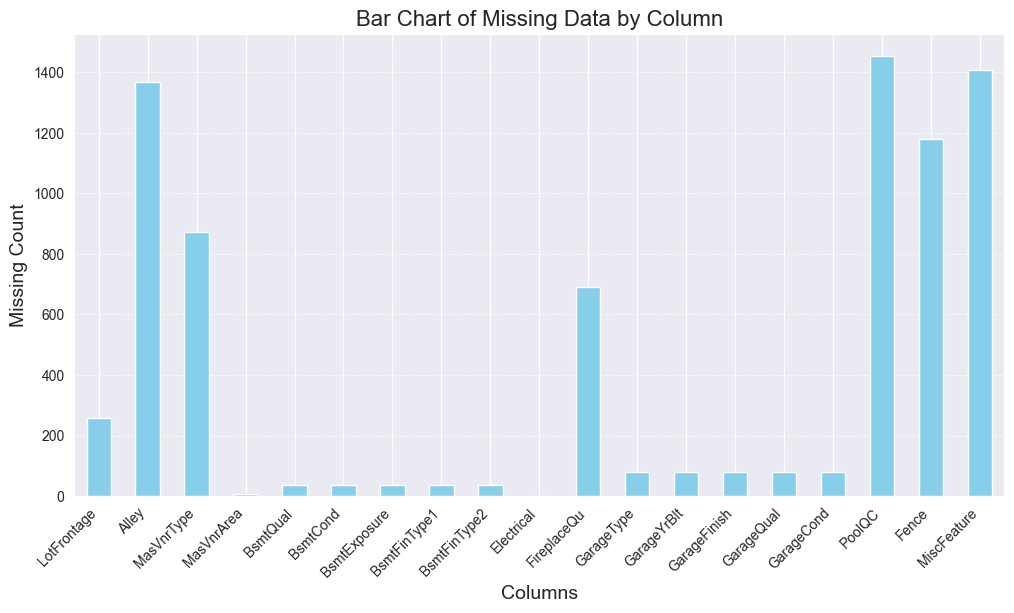


Outlier Summary:
               Outlier Count
LotFrontage               88
LotArea                   69
OverallQual                2
OverallCond              125
YearBuilt                  7
MasVnrArea                96
BsmtFinSF1                 7
BsmtFinSF2               167
BsmtUnfSF                 29
TotalBsmtSF               61
1stFlrSF                  20
2ndFlrSF                   2
LowQualFinSF              26
GrLivArea                 31
BsmtFullBath               1
BsmtHalfBath              82
BedroomAbvGr              35
KitchenAbvGr              68
TotRmsAbvGrd              30
Fireplaces                 5
GarageCars                 5
GarageArea                21
WoodDeckSF                32
OpenPorchSF               77
EnclosedPorch            208
3SsnPorch                 24
ScreenPorch              116
PoolArea                   7
MiscVal                   52
SalePrice                 61


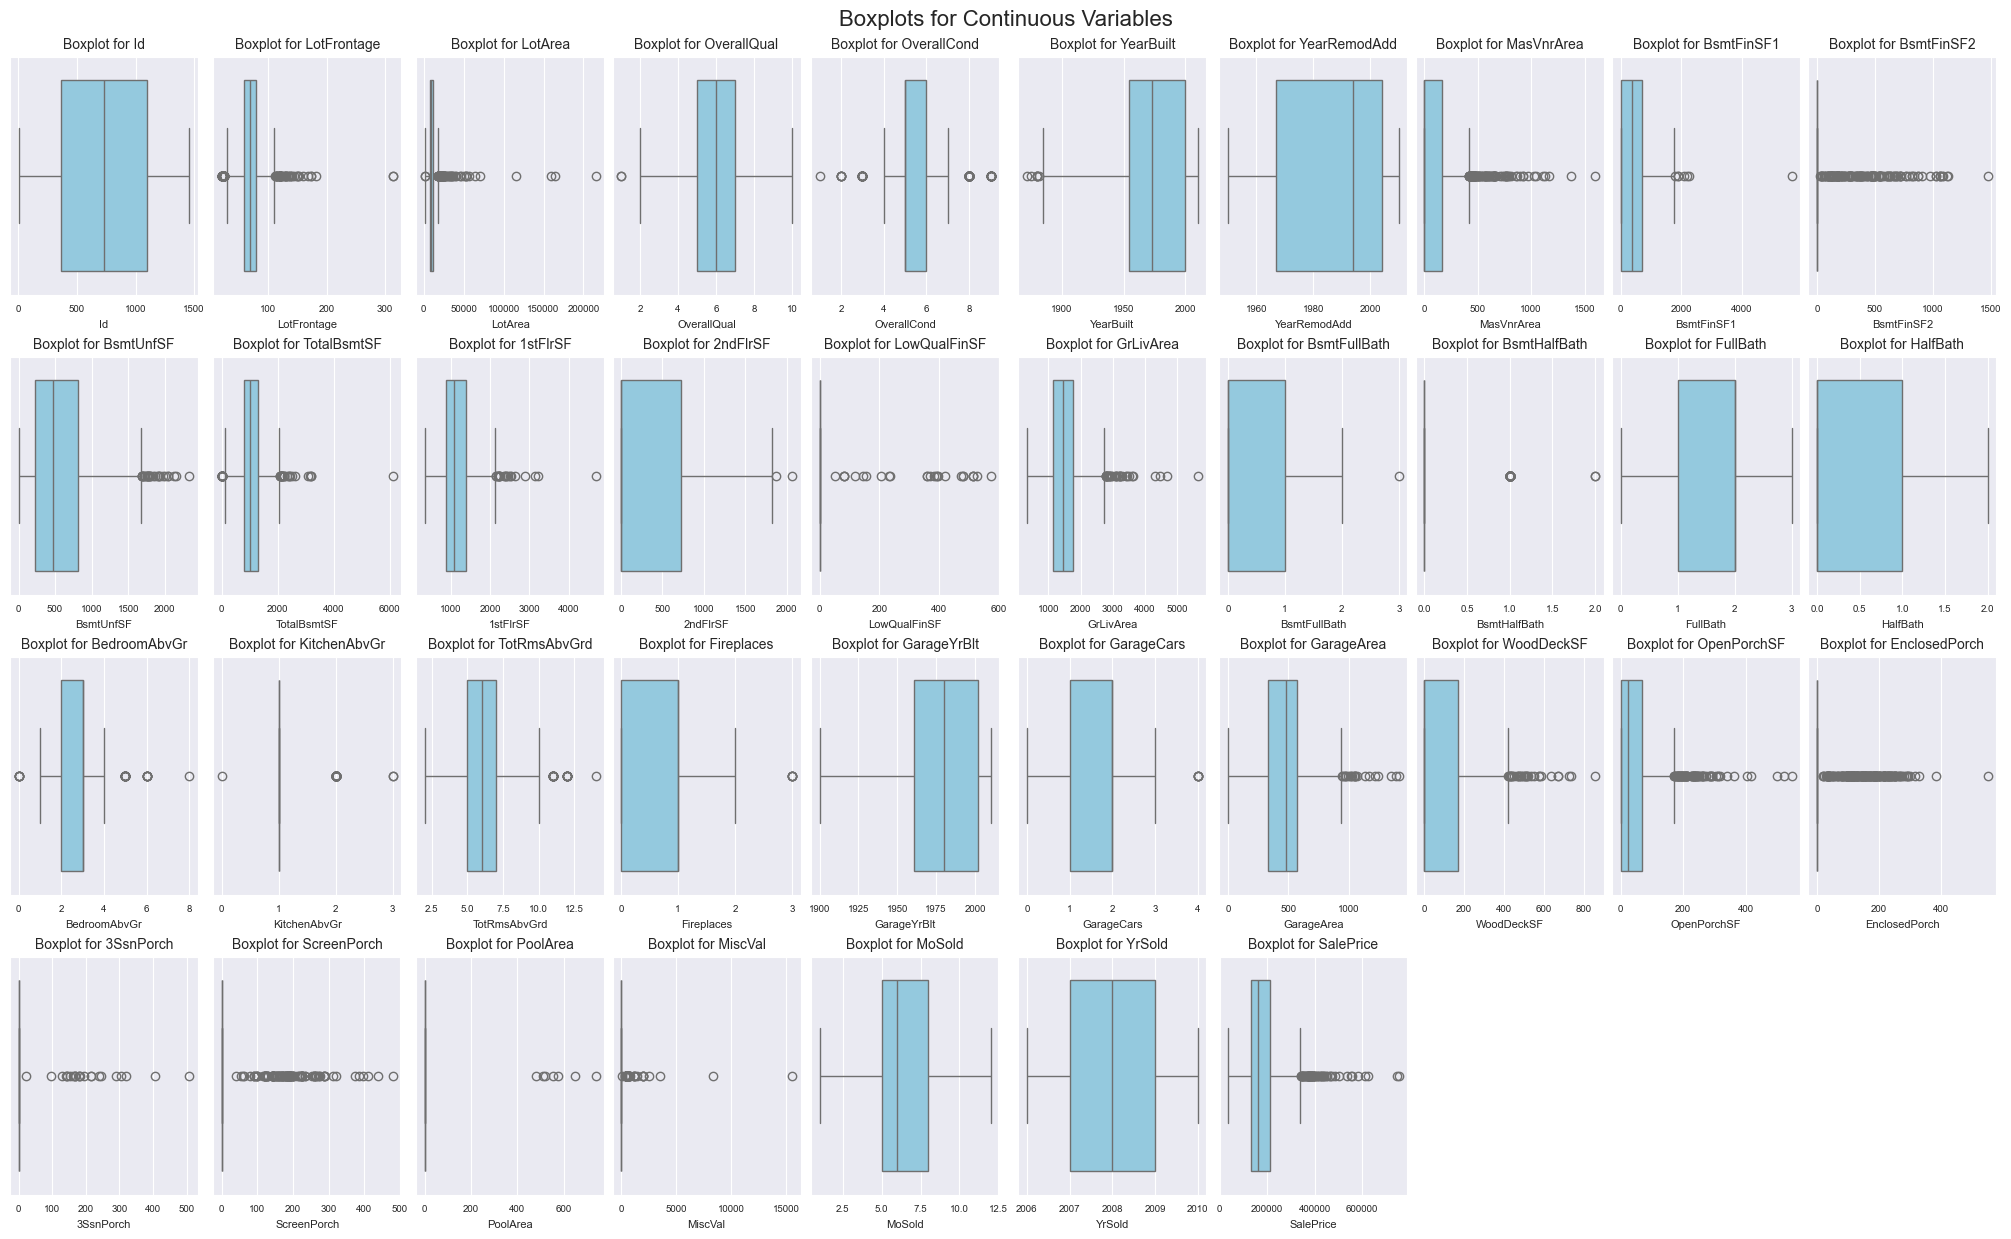

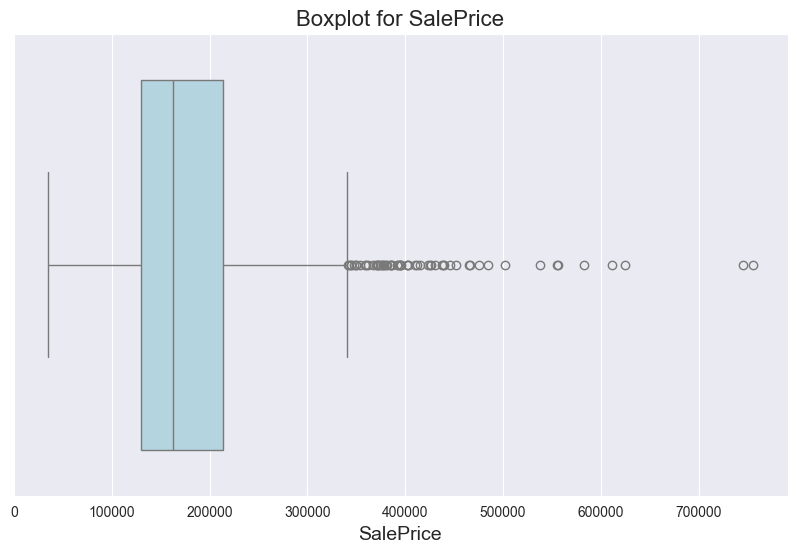

Rows with infinite values:
Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []



Id  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    70.049958   10516.828082     6.099315     5.575342   
std     421.610009    22.024023    9981.264932     1.382997     1.112799   
min       1.000000    21.000000    1300.000000     1.000000     1.000000   
25%     365.750000    60.000000    7553.500000     5.000000     5.000000   
50%     730.500000    70.049958    9478.500000     6.000000     5.000000   
75%    1095.250000    79.000000   11601.500000     7.000000     6.000000   
max    1460.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.685262   443.639726    46.549315  ...   
std      30.202904     20.645407   180.569112   456.098091   161.319273  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000     0.000000  ...   
50%    1973.000000   1994.000000     0.000000   383.500000     0.000000  ...   
75%    2000.000000   2004.000000   164.250000   712.250000     0.000000  ...   
max    2010.000000   2010.000000  1600.000000  5644.000000  1474.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 37 columns]

In [10]:
### THIS SESSSION INVESTIGATES TRAIN DATA ###

### Step 1: Investigate Missing Values ###

# Calculate missing values for each column
missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

### Step 2: Investigate Outliers ###

# Use boxplots to identify outliers for continuous variables
continuous_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns

# Detect outliers using the IQR method
outlier_summary = {}
for column in continuous_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_data[(train_data[column] < lower_bound) | (train_data[column] > upper_bound)]
    outlier_count = len(outliers)
    outlier_summary[column] = outlier_count

# Display the outlier summary
outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_summary_df = outlier_summary_df[outlier_summary_df['Outlier Count'] > 0]  # Filter columns with outliers
print("\nOutlier Summary:")
print(outlier_summary_df)


def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    """
    Plot boxplots for all numeric columns in a DataFrame in a grid layout.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        max_rows (int): The maximum number of rows in the grid.
        max_cols (int): The maximum number of boxplots per row.
    """
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(train_data)

### Optional: Visualize Outliers in 'SalePrice' ###
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['SalePrice'], color='lightblue')
plt.title("Boxplot for SalePrice", fontsize=16)
plt.xlabel("SalePrice", fontsize=14)
plt.show()

# Capture rows with infinite values
rows_with_infinity = train_data[(train_data == float('inf')).any(axis=1) | (train_data == -float('inf')).any(axis=1)]
print("Rows with infinite values:")
print(rows_with_infinity)

# Capture rows with NaN in the "SalePrice" column
rows_with_nan_SalePrice = train_data[train_data['SalePrice'].isna()]
print("Rows with NaN in the 'SalePrice' column:")
print(rows_with_nan_SalePrice)

# Replace infinite values with NaN
train_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

### NEW Pre-processing  ###

# Verify if missing values are handled
missing_values_summary = train_data.isnull().sum()

# Separate numerical and categorical columns
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = train_data.select_dtypes(include=['object','category']).columns

# Impute missing values for numerical columns with the mean
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].mean())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

# Verify if missing values are handled
missing_values_summary = train_data.isnull().sum()

pd.set_option('display.max_rows', None)  # Show all rows
print('Missing Value Summary:')
print(missing_values_summary)

# Display a summary of the dataset using the describe() method
data_description = train_data.describe()

# Show the summary statistics
data_description

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6

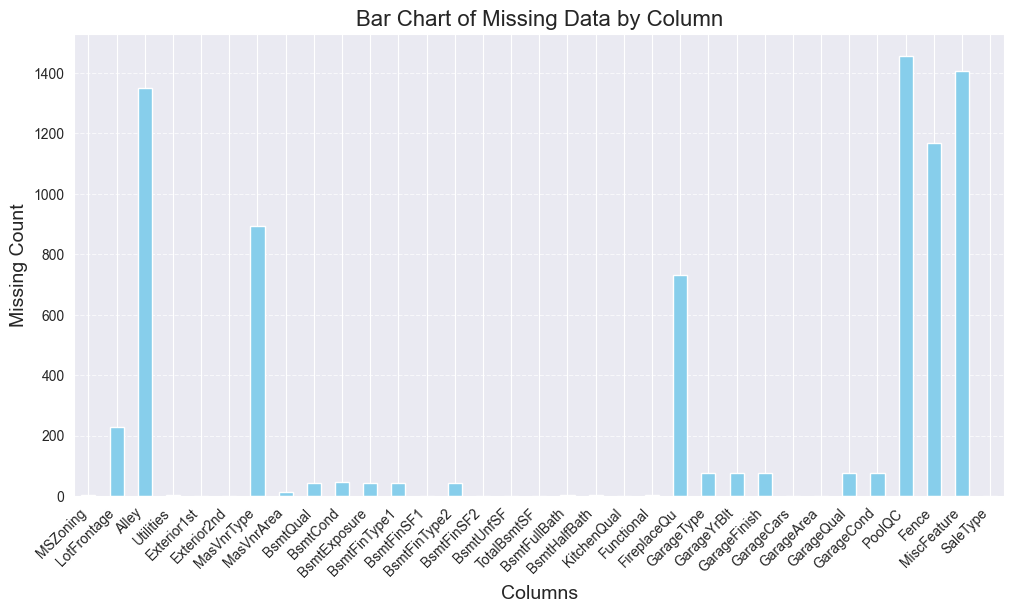

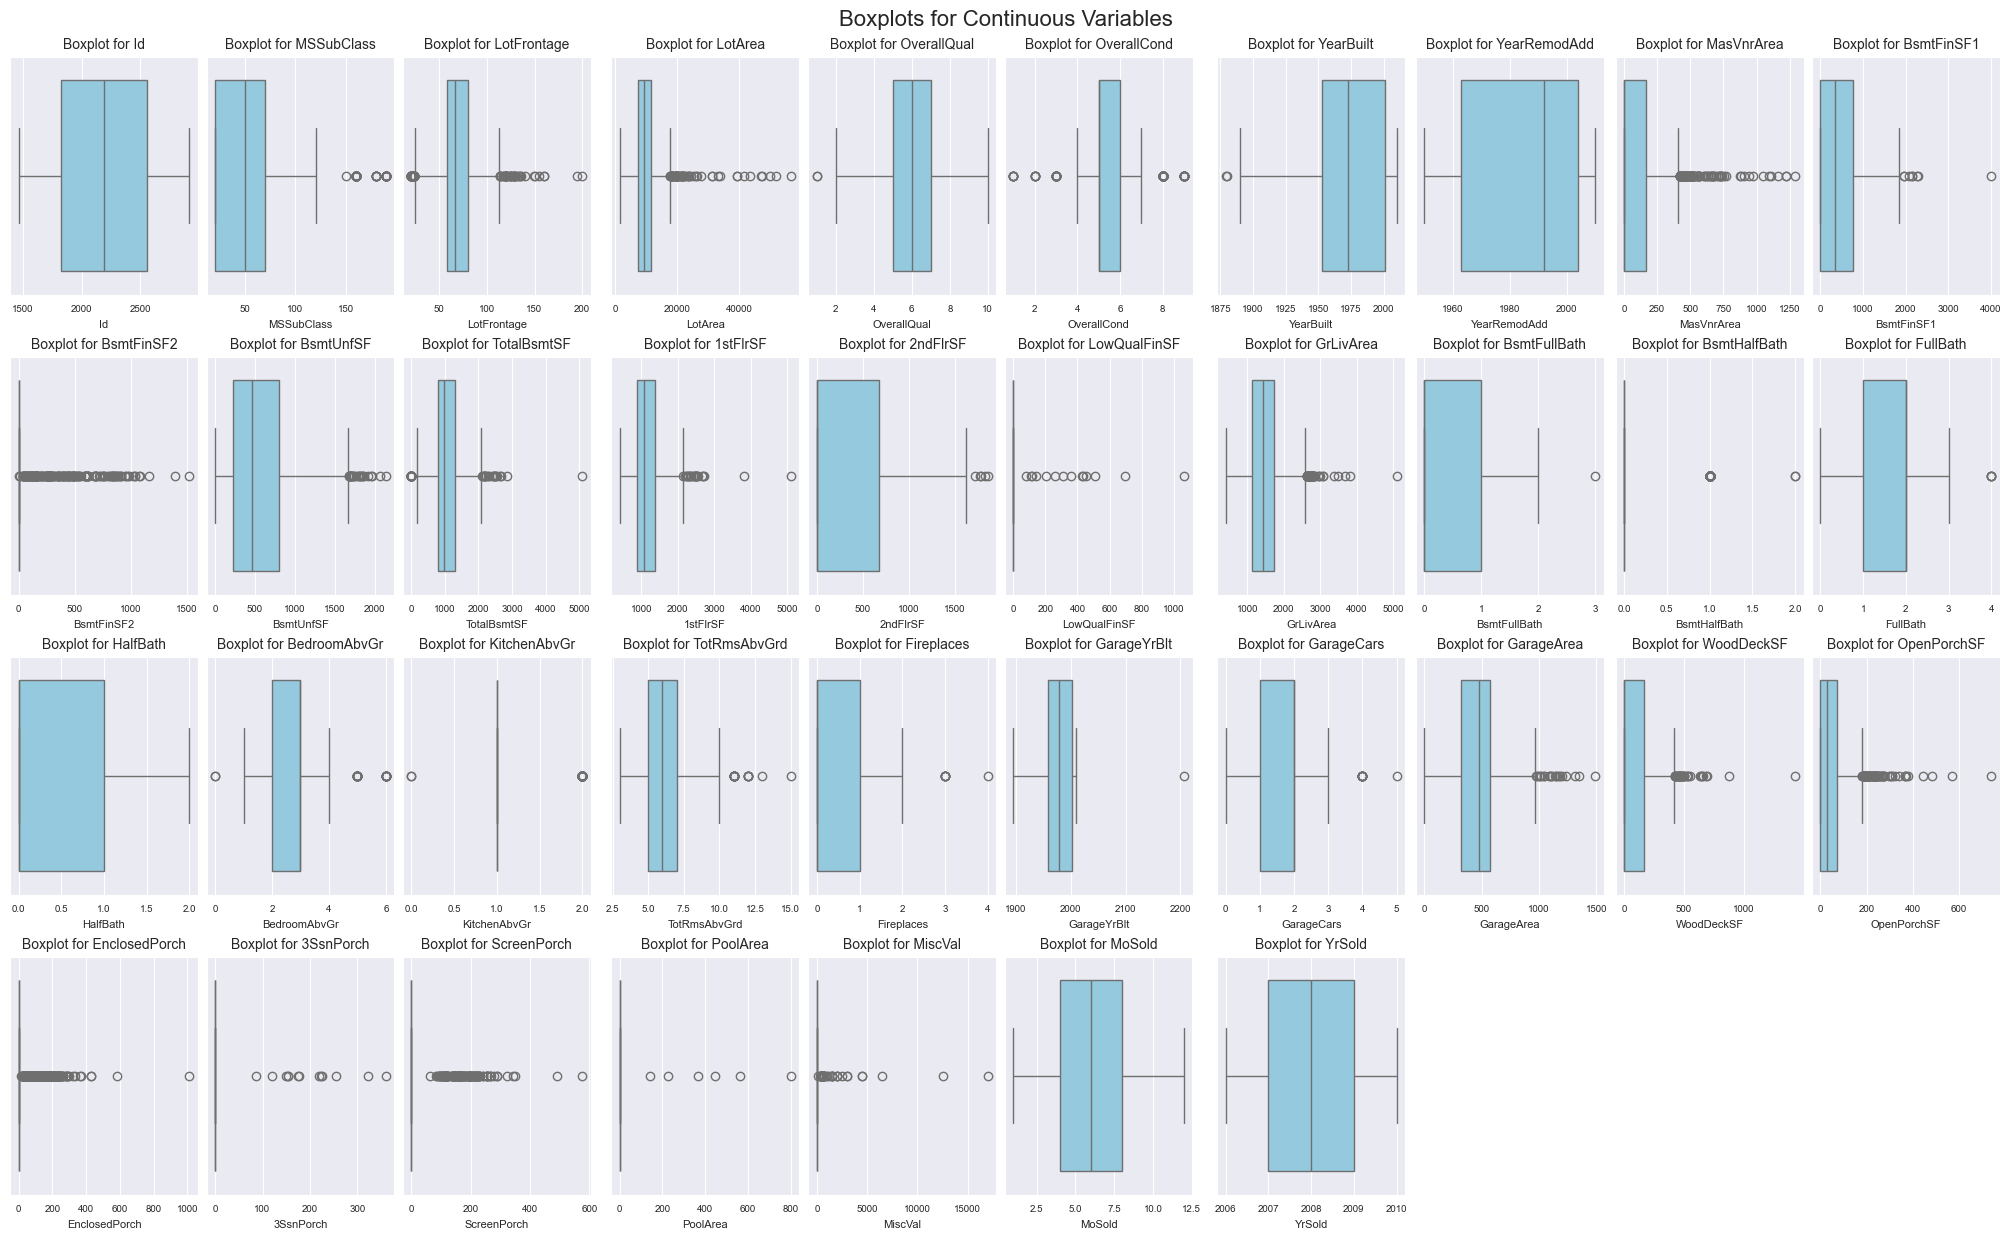

Rows with infinite values:
Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition]
Index: []

[0 rows x 8

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1459.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    20.561228   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    60.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    68.580357   9399.000000     6.000000   
75%    2554.500000    70.000000    78.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  ...   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704  ...   
std       1.113740    30.390071     21.130467   176.709824   455.111888  ...   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1992.000000     0.000000   351.000000  ...   
75%       6.000000  2001.000000   2004.000000   162.000000   752.000000  ...   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1459.000000  1459.000000  1459.000000    1459.000000  1459.000000   
mean    472.768861    93.174777    48.313914      24.243317     1.794380   
std     216.974165   127.744882    68.883364      67.227765    20.207842   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     318.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   360.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  
mean     17.064428     1.744345     58.167923     6.104181  2007.769705  
std      56.609763    30.491646    630.806978     2.722432     1.301740  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 37 columns]

In [165]:
### THIS SESSION INVESTIGATES TEST DATA ###

### Step 1: Investigate Missing Values ###
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/3_ModelAssign3_Kaggle/test.csv", header=0, sep=",")
print(test_data.head())

# Calculate missing values for each column
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(test_data)



# Capture rows with infinite values
rows_with_infinity = test_data[(test_data == float('inf')).any(axis=1) | (test_data == -float('inf')).any(axis=1)]
print("Rows with infinite values:")
print(rows_with_infinity)

# Replace infinite values with NaN
test_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)


# Check # of row
print(test_data.info())


## New Pre-processing ###

# Separate numerical and categorical columns
numerical_columns = test_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = test_data.select_dtypes(include=['object','category']).columns

# Impute missing values for numerical columns with the mean
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Verify if missing values are handled
missing_values_summary = test_data.isnull().sum()

pd.set_option('display.max_rows', None)  # Show all rows
print('Missing Value Summary:')
print(missing_values_summary)

# Display a summary of the dataset using the describe() method
data_description = test_data.describe()

# Show the summary statistics
data_description


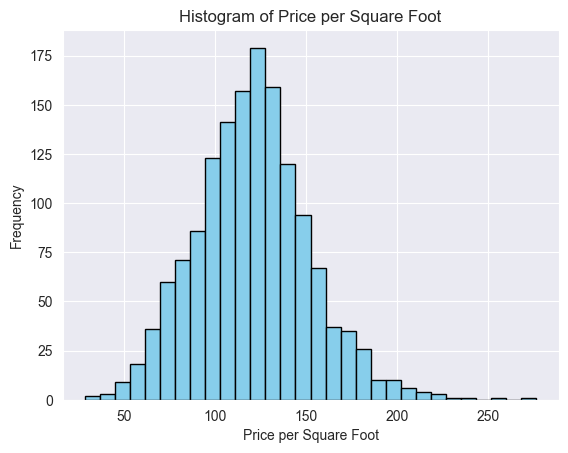

In [166]:

# Create new columns in the DataFrame
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['logSalePrice'] = np.log(train_data['SalePrice'])
train_data['price_sqft'] = train_data['SalePrice'] / train_data['GrLivArea']

# Plot a histogram of 'price_sqft'
plt.hist(train_data['price_sqft'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Price per Square Foot')
plt.xlabel('Price per Square Foot')
plt.ylabel('Frequency')
plt.show()

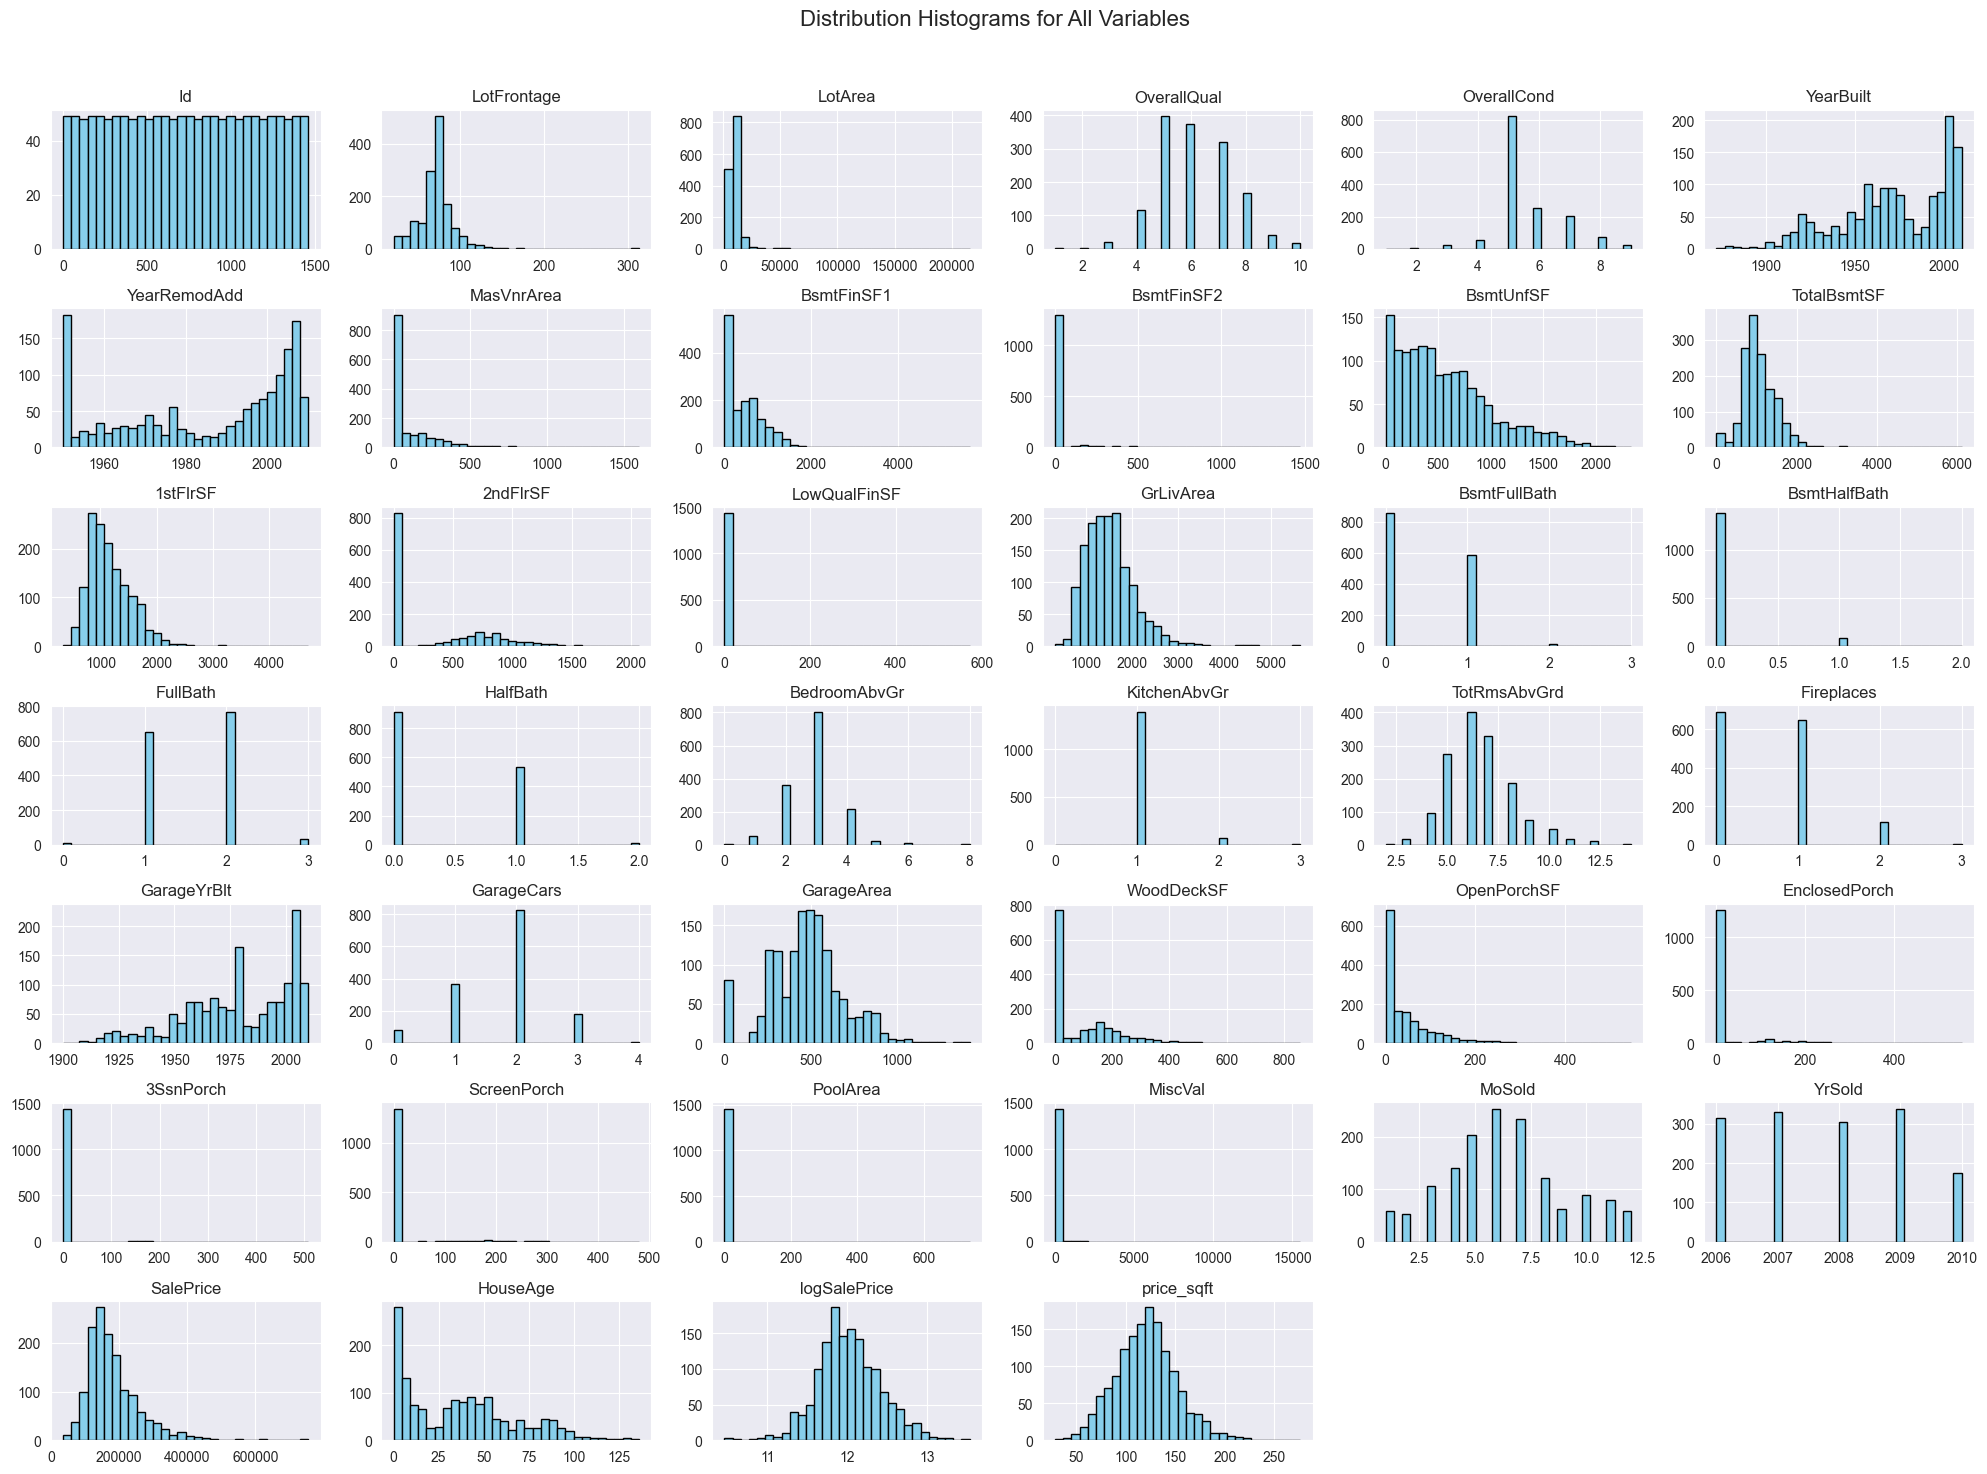

In [167]:
import matplotlib.pyplot as plt

# Plot distribution histograms for all variables
train_data.hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distribution Histograms for All Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [168]:
## Remove Outliers,Filter specific values ###

train_data_filtered = train_data[
    (train_data['LotArea'] <= 15000) &                                # Remove Outliers (i.e. exclude lots over 15000 sqft)
    (train_data['GrLivArea'] < 3000) &                                  # Remove Outliers (i.e. exclude houses over 3,000 sqft)
    (train_data['SalePrice'] <= 335000)                              # Remove Outliers for sales prices > $335K
]

row_count = len(train_data)
print(f"Number of rows before Outliers are removed: {row_count}")

row_count = len(train_data_filtered)
print(f"Number of rows after Outliers are removed: {row_count}")

train_data = train_data_filtered.copy()

Number of rows before Outliers are removed: 1460
Number of rows after Outliers are removed: 1285


In [169]:
train_data.describe()

Id  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1285.000000  1285.000000   1285.000000  1285.000000  1285.000000   
mean    730.480934    67.578009   8840.480156     5.956420     5.592218   
std     421.133779    18.112397   2884.730019     1.272021     1.108703   
min       1.000000    21.000000   1300.000000     1.000000     1.000000   
25%     366.000000    60.000000   7200.000000     5.000000     5.000000   
50%     737.000000    70.049958   9056.000000     6.000000     5.000000   
75%    1094.000000    76.000000  10778.000000     7.000000     6.000000   
max    1460.000000   182.000000  14963.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1285.000000   1285.000000  1285.000000  1285.000000  1285.000000  ...   
mean   1970.162646   1984.063035    88.944834   397.817121    42.883268  ...   
std      30.208118     20.743424   154.830711   390.698964   151.001910  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1952.000000   1966.000000     0.000000     0.000000     0.000000  ...   
50%    1972.000000   1992.000000     0.000000   360.000000     0.000000  ...   
75%    2000.000000   2003.000000   145.000000   663.000000     0.000000  ...   
max    2009.000000   2010.000000  1600.000000  1880.000000  1474.000000  ...   

         3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold  \
count  1285.000000  1285.000000  1285.000000   1285.000000  1285.000000   
mean      2.919066    13.948638     0.952529     40.026459     6.325292   
std      27.653136    52.847873    24.176694    471.851258     2.689837   
min       0.000000     0.000000     0.000000      0.000000     1.000000   
25%       0.000000     0.000000     0.000000      0.000000     5.000000   
50%       0.000000     0.000000     0.000000      0.000000     6.000000   
75%       0.000000     0.000000     0.000000      0.000000     8.000000   
max     508.000000   480.000000   648.000000  15500.000000    12.000000   

            YrSold      SalePrice     HouseAge  logSalePrice   price_sqft  
count  1285.000000    1285.000000  1285.000000   1285.000000  1285.000000  
mean   2007.834241  166296.408560    37.671595     11.962099   117.986446  
std       1.323668   57160.542522    30.246565      0.351029    28.276629  
min    2006.000000   34900.000000     0.000000     10.460242    30.372058  
25%    2007.000000  127000.000000     8.000000     11.751942    99.194940  
50%    2008.000000  155000.000000    36.000000     11.951180   118.809126  
75%    2009.000000  197500.000000    56.000000     12.193494   136.585366  
max    2010.000000  335000.000000   136.000000     12.721886   196.731235  

[8 rows x 40 columns]

In [170]:
### Reduce noise in OverallQuality by Creating a new variable OverallQuality with 2 bins"

# Define the bins and labels
bins = [0, 6, float('inf')]  # Define two intervals: [0, 6) and [6, inf)
labels = ['Low', 'High']

# Transform 'OverallQual' from seven categories to two. Purpose is to reduce noise.
train_data["OverallQual"] = pd.cut(
    train_data["OverallQual"], bins=bins, labels=labels, right=False
)

train_data = train_data.copy()

In [171]:
### Reduce noise in HouseAge by grouping in 5 bins"

# Define the bins and labels
bins = [0, 10, 20, 30, 140]
labels = [1, 2, 3,4]

# Create a new column 'HouseAge' by grouping 'HouseAge'
train_data["HouseAge"] = pd.cut(
    train_data["HouseAge"], bins=bins, labels=labels, right=False
)

train_data = train_data.copy()

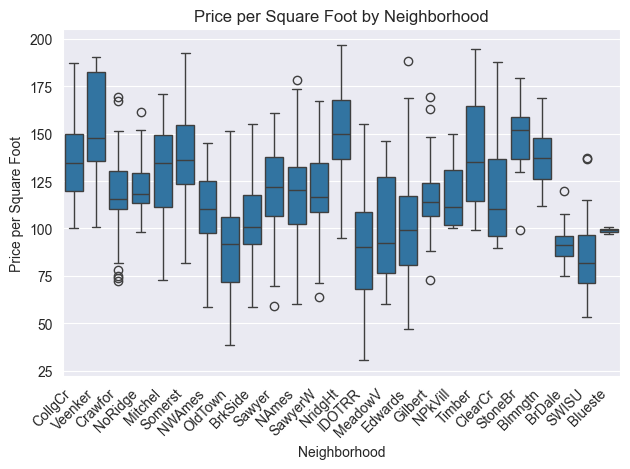

In [172]:
sns.boxplot(data=train_data, x='Neighborhood', y='price_sqft')
plt.xticks(rotation=45, ha='right')
plt.title('Price per Square Foot by Neighborhood')
plt.ylabel('Price per Square Foot')
plt.xlabel('Neighborhood')
plt.tight_layout()
plt.show()

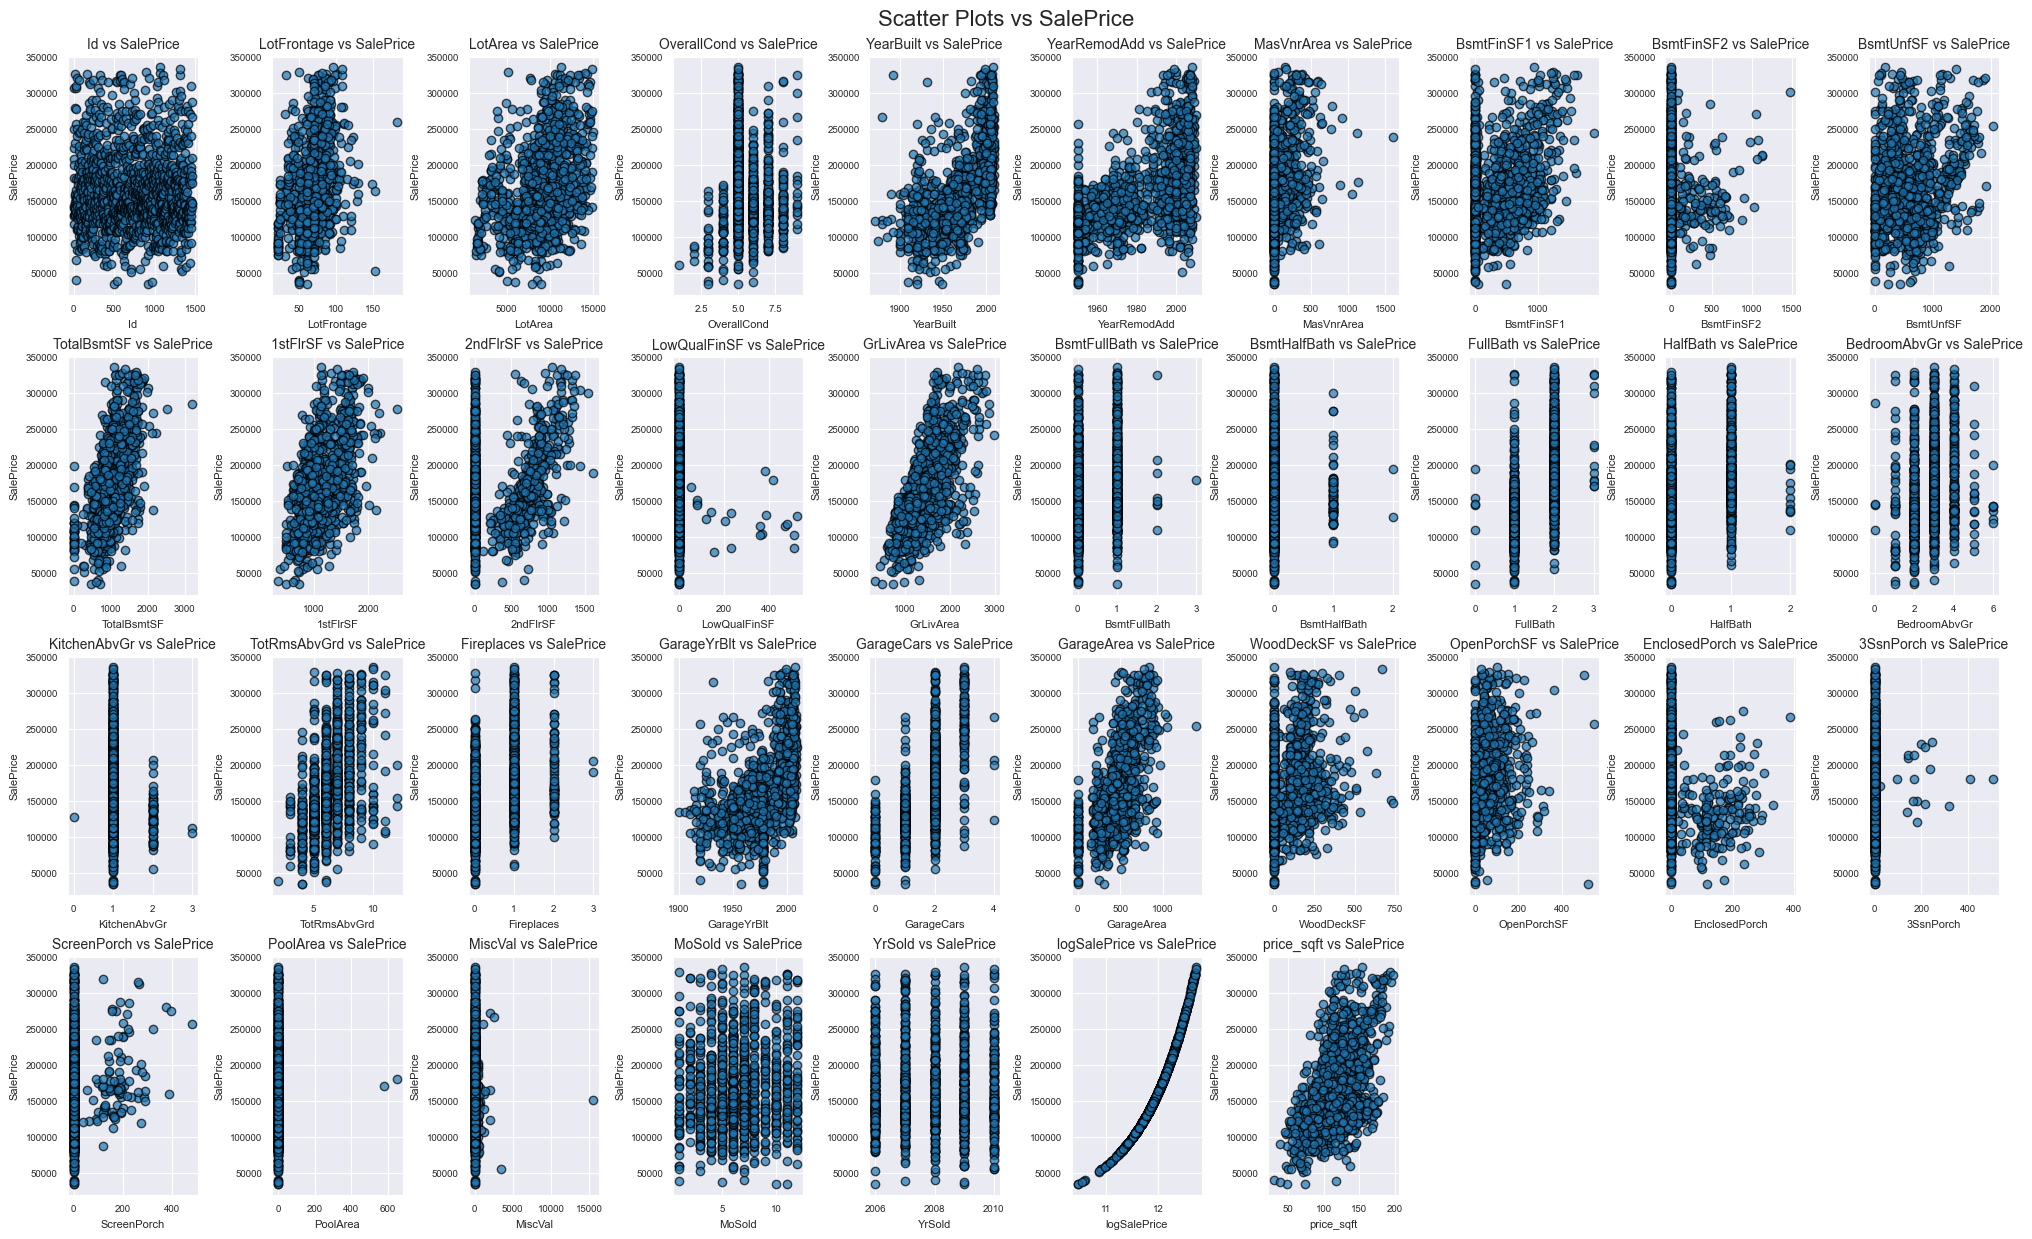

In [173]:
## Analyze collinearity with scatter plots ###

import matplotlib.pyplot as plt

def scatter_plots_with_target(data, target, max_rows=8, max_cols=10):

    # Select numeric columns and exclude the target variable
    numeric_columns = data.select_dtypes(include=[np.number]).columns.drop(target)
    num_plots = len(numeric_columns)

    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    # Loop through each numeric column and create scatter plots
    for i, column in enumerate(numeric_columns):
        axes[i].scatter(data[column], data[target], alpha=0.7, edgecolor='k')
        axes[i].set_title(f"{column} vs {target}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].set_ylabel(target, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(numeric_columns), len(axes)):
        axes[i].axis('off')

    # Display the plots
    plt.suptitle(f"Scatter Plots vs {target}", fontsize=16, y=1.02)
    plt.show()

# Example usage with train_data_filtered
scatter_plots_with_target(train_data, target="SalePrice", max_rows=8, max_cols=10)


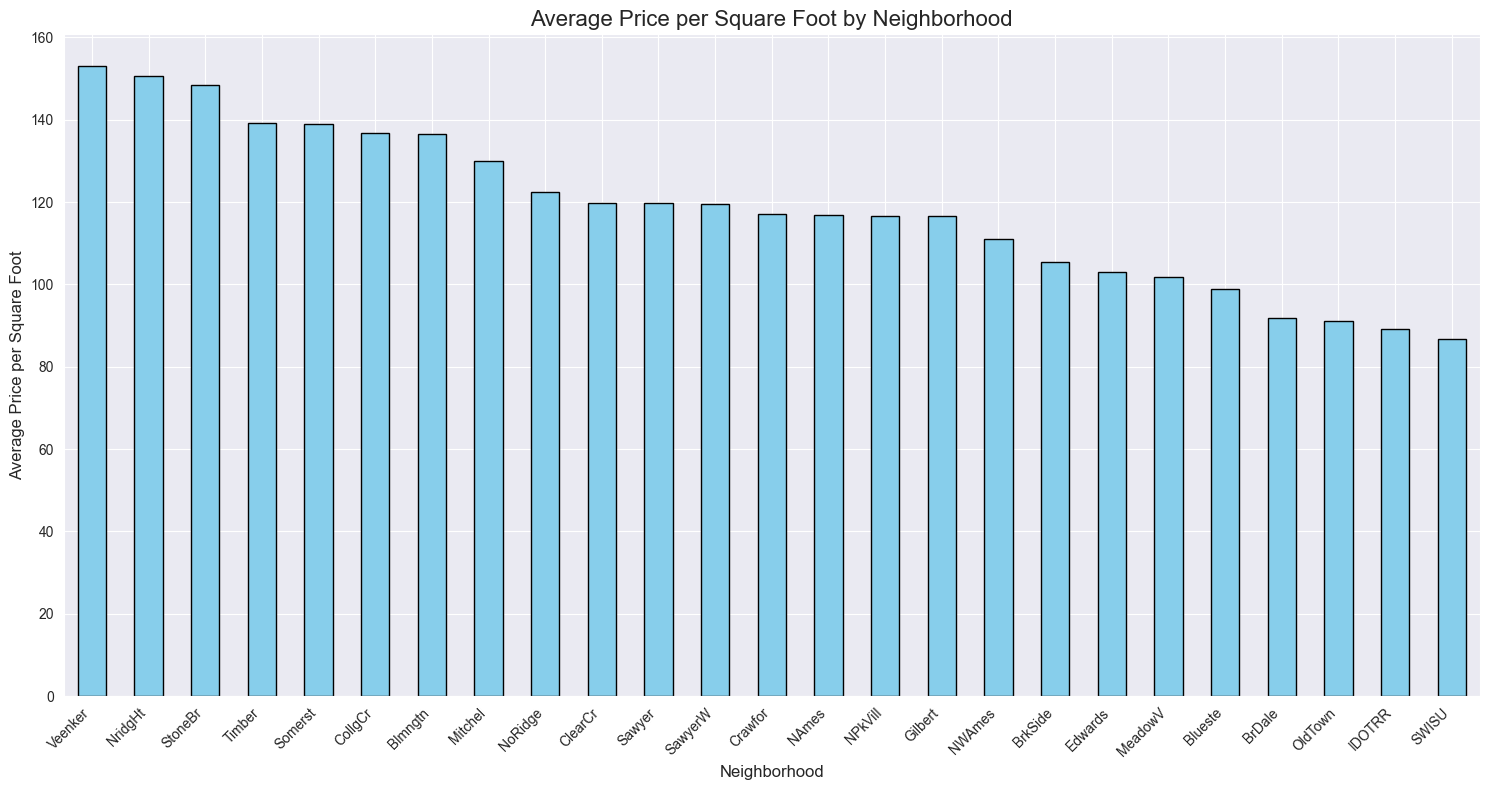

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average Price_per_sqft for each Neighborhood
neighborhood_avg_price = train_data.groupby('Neighborhood')['price_sqft'].mean().sort_values(ascending=False)

# Plotting the relationship
plt.figure(figsize=(15, 8))
neighborhood_avg_price.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Price per Square Foot by Neighborhood', fontsize=16)
plt.ylabel('Average Price per Square Foot', fontsize=12)
plt.xlabel('Neighborhood', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


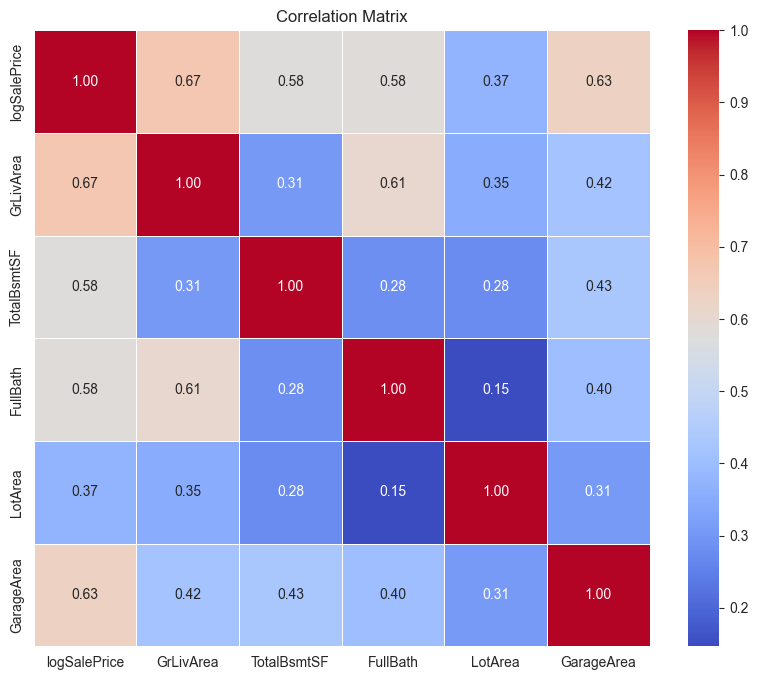

In [175]:
## Select a smaller set of variables ###

subdat = train_data[["logSalePrice", "GrLivArea","TotalBsmtSF", "FullBath", "LotArea", "GarageArea"]]

# Compute the correlation matrix
mcor = subdat.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(mcor, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, 
            square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Correlation Matrix")
plt.show()

In [176]:
subdat.head()

logSalePrice  GrLivArea  TotalBsmtSF  FullBath  LotArea  GarageArea
0     12.247694       1710          856         2     8450         548
1     12.109011       1262         1262         2     9600         460
2     12.317167       1786          920         2    11250         608
3     11.849398       1717          756         1     9550         642
4     12.429216       2198         1145         2    14260         836

In [177]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'logSalePrice', 'price_sqft'],
      dtype='object')

In [178]:

# Perform dummy coding for specified columns
columns_to_dummy = ["BldgType", "LotConfig", "LotShape","Neighborhood","BsmtExposure","MSZoning"]

# Create dummy variables
data_dummies = pd.get_dummies(train_data, columns=columns_to_dummy, drop_first=True, dtype=int)

# Display the first few rows of the transformed dataset
data_dummies.describe()

# Replaces the original columns in `train_data` with the ones from `data_dummies`, while keeping all other columns

Id  LotFrontage       LotArea  OverallCond    YearBuilt  \
count  1285.000000  1285.000000   1285.000000  1285.000000  1285.000000   
mean    730.480934    67.578009   8840.480156     5.592218  1970.162646   
std     421.133779    18.112397   2884.730019     1.108703    30.208118   
min       1.000000    21.000000   1300.000000     1.000000  1872.000000   
25%     366.000000    60.000000   7200.000000     5.000000  1952.000000   
50%     737.000000    70.049958   9056.000000     5.000000  1972.000000   
75%    1094.000000    76.000000  10778.000000     6.000000  2000.000000   
max    1460.000000   182.000000  14963.000000     9.000000  2009.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count   1285.000000  1285.000000  1285.000000  1285.000000  1285.000000  ...   
mean    1984.063035    88.944834   397.817121    42.883268   559.562646  ...   
std       20.743424   154.830711   390.698964   151.001910   427.670496  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1966.000000     0.000000     0.000000     0.000000   223.000000  ...   
50%     1992.000000     0.000000   360.000000     0.000000   479.000000  ...   
75%     2003.000000   145.000000   663.000000     0.000000   798.000000  ...   
max     2010.000000  1600.000000  1880.000000  1474.000000  2042.000000  ...   

       Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker  \
count           1285.000000          1285.000000           1285.000000   
mean               0.011673             0.021012              0.006226   
std                0.107452             0.143479              0.078688   
min                0.000000             0.000000              0.000000   
25%                0.000000             0.000000              0.000000   
50%                0.000000             0.000000              0.000000   
75%                0.000000             0.000000              0.000000   
max                1.000000             1.000000              1.000000   

       BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  MSZoning_FV  \
count      1285.000000      1285.000000      1285.000000  1285.000000   
mean          0.058366         0.074708         0.721401     0.048249   
std           0.234525         0.263022         0.448484     0.214375   
min           0.000000         0.000000         0.000000     0.000000   
25%           0.000000         0.000000         0.000000     0.000000   
50%           0.000000         0.000000         1.000000     0.000000   
75%           0.000000         0.000000         1.000000     0.000000   
max           1.000000         1.000000         1.000000     1.000000   

       MSZoning_RH  MSZoning_RL  MSZoning_RM  
count  1285.000000  1285.000000  1285.000000  
mean      0.011673     0.766537     0.166537  
std       0.107452     0.423199     0.372707  
min       0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000  
50%       0.000000     1.000000     0.000000  
75%       0.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000  

[8 rows x 80 columns]

In [179]:
# Update train_data

train_data = data_dummies.copy()


In [180]:
len(train_data.columns)

120

In [181]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64', 'int32', 'uint8']).columns
print(", ".join(f"'{col}'" for col in numeric_columns))

'Id', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'logSalePrice', 'price_sqft', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes'

In [182]:
categorical_columns = train_data.select_dtypes(include=['object','category']).columns
print(", ".join(f"'{col}'"for col in categorical_columns))

'MSSubClass', 'Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'HouseStyle', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'HouseAge'


In [183]:
boolean_columns = train_data.select_dtypes(include=['boolean']).columns
boolean_columns

Index([], dtype='object')

In [184]:
print(train_data.dtypes)

Id                         int64
MSSubClass              category
LotFrontage              float64
LotArea                    int64
Street                    object
Alley                     object
LandContour               object
Utilities                 object
LandSlope                 object
Condition1                object
Condition2                object
HouseStyle                object
OverallQual             category
OverallCond                int64
YearBuilt                  int64
YearRemodAdd               int64
RoofStyle                 object
RoofMatl                  object
Exterior1st               object
Exterior2nd               object
MasVnrType                object
MasVnrArea               float64
ExterQual                 object
ExterCond                 object
Foundation                object
BsmtQual                  object
BsmtCond                  object
BsmtFinType1              object
BsmtFinSF1                 int64
BsmtFinType2              object
BsmtFinSF2

In [185]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64', 'int8']).columns
print(", ".join(f"'{col}'"for col in numeric_columns))

'Id', 'LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'logSalePrice', 'price_sqft', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes'

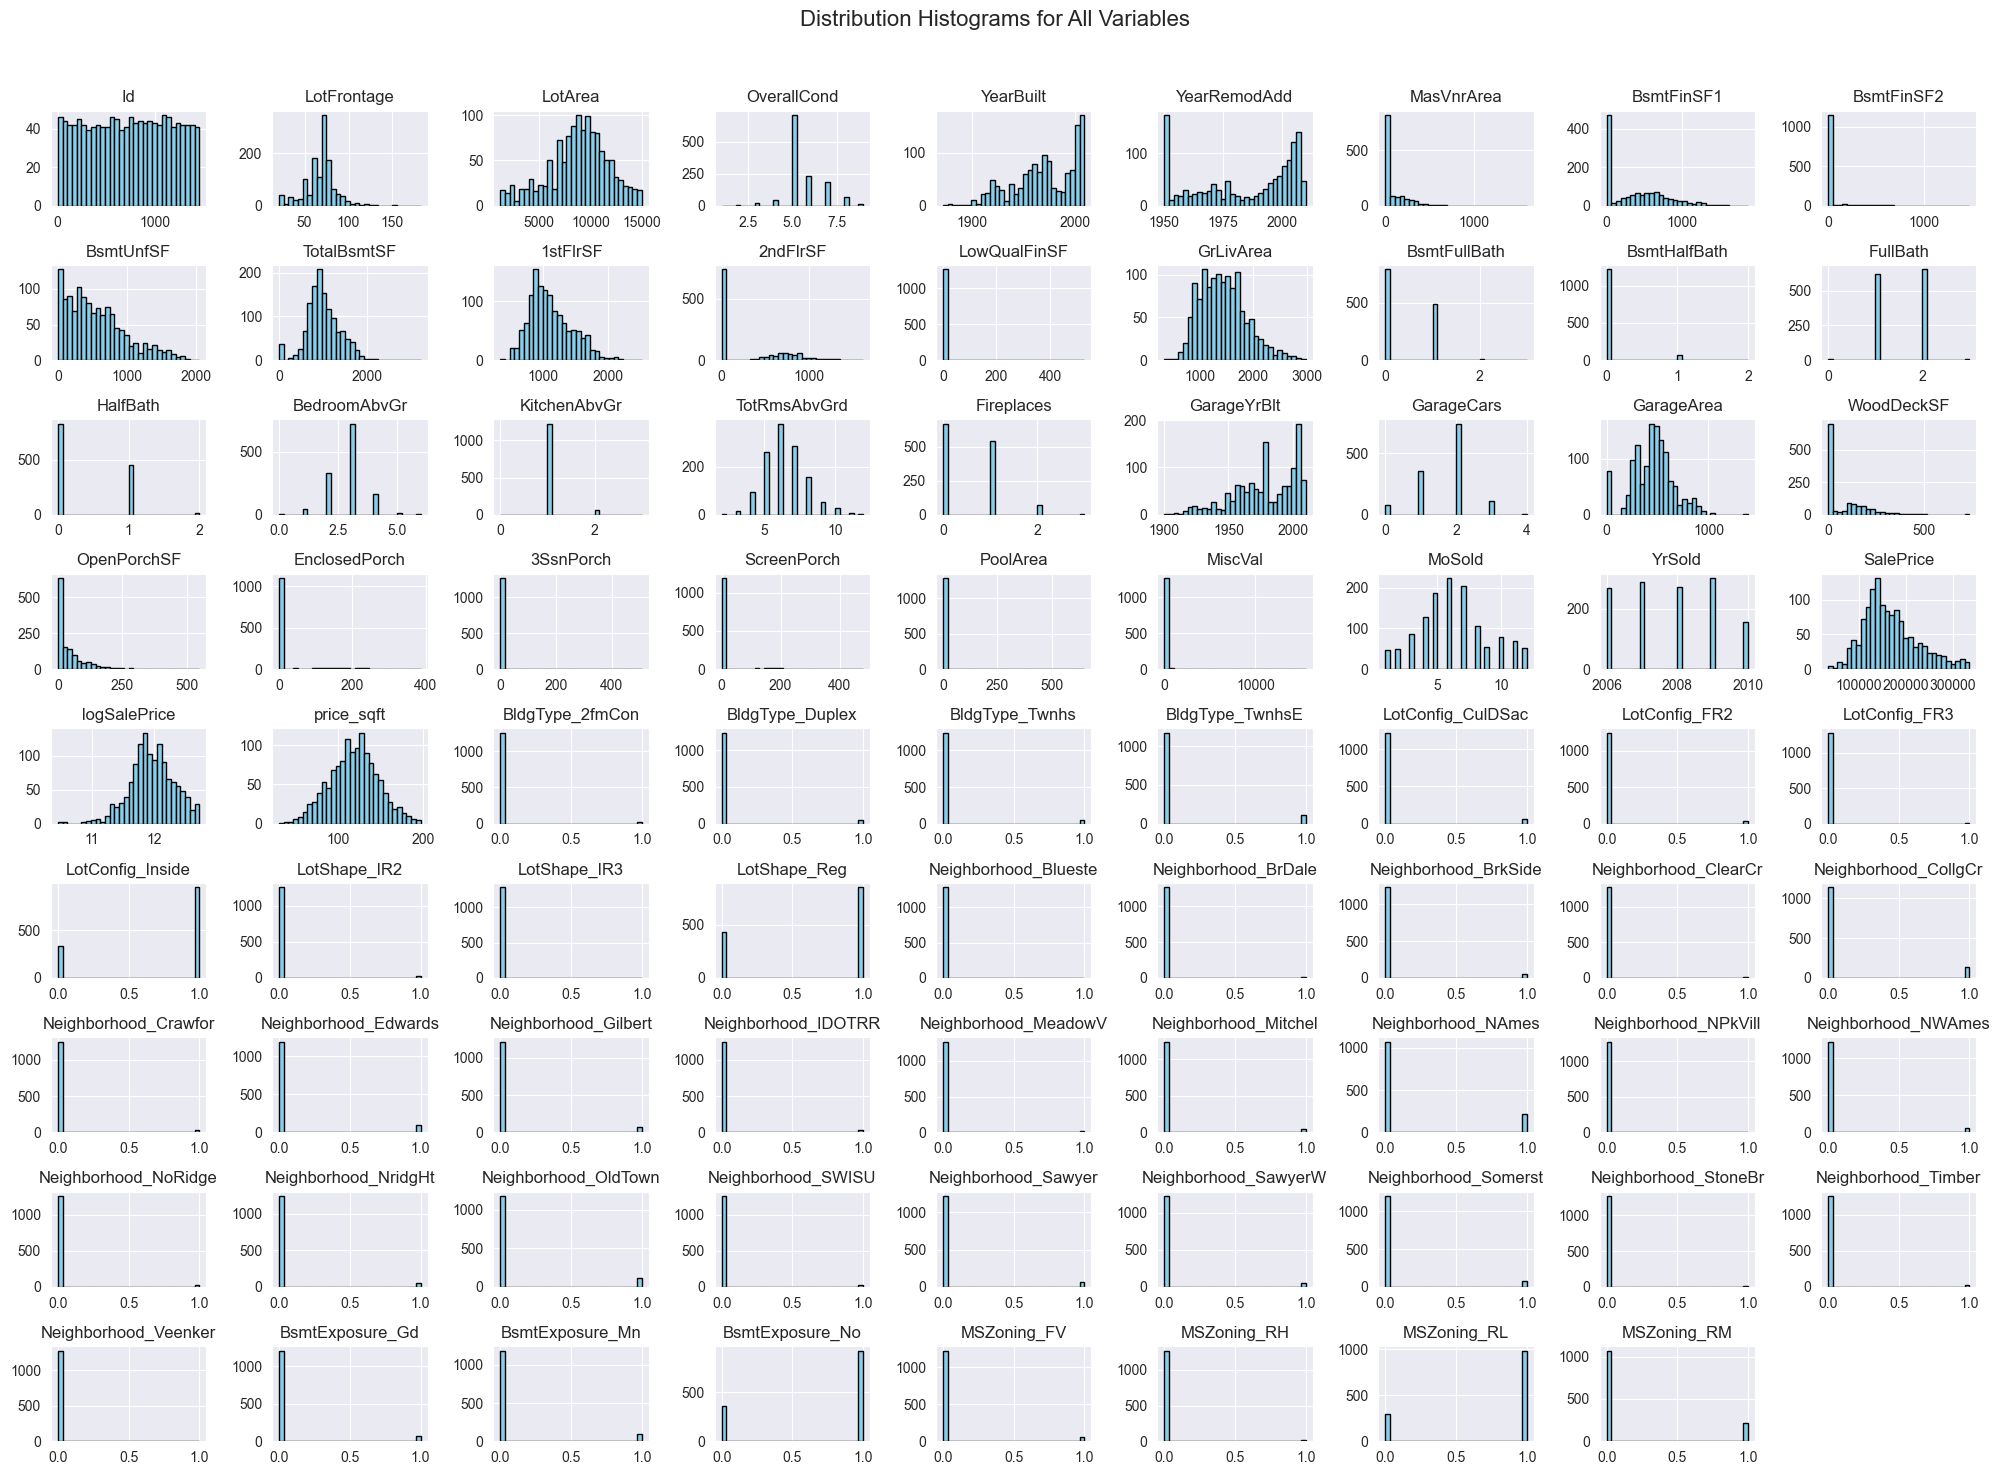

In [186]:
import matplotlib.pyplot as plt

# Plot distribution histograms for all variables
train_data.hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distribution Histograms for All Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [187]:
# Define ordinal mappings for transformation
ordinal_mappings = {
    "BedroomAbvGr": CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8], ordered=True),
    "BsmtCond": CategoricalDtype(categories=["NA","Po", "Fa", "TA", "Gd", "Ex"], ordered=True),
    "BsmtFullBath": CategoricalDtype(categories=[0, 1, 2, 3], ordered=True),
    "ExterCond": CategoricalDtype(categories=["Po", "Fa", "TA", "Gd", "Ex"], ordered=True),
    "Fence": CategoricalDtype(categories=["NA","MnWw", "GdWo", "MnPrv", "GdPrv"], ordered=True),
    "FireplaceQu": CategoricalDtype(categories=["NA","Po", "Fa", "TA", "Gd", "Ex"], ordered=True),
    "FullBath": CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=True),
    "GarageQual": CategoricalDtype(categories=["NA","Po", "Fa", "TA", "Gd", "Ex"], ordered=True),
    "HalfBath": CategoricalDtype(categories=[0, 1, 2], ordered=True),
    "HouseAge": CategoricalDtype(categories=[1, 2, 3,4], ordered=True),  # Example
    "KitchenQual": CategoricalDtype(categories=["Po", "Fa", "TA", "Gd", "Ex"], ordered=True),
    "OverallQual": CategoricalDtype(categories=['Low', 'High'], ordered=True),
    "HeatingQC": CategoricalDtype(categories=["Po", "Fa", "TA", "Gd", "Ex"], ordered=True)
}

# Convert ordinal variables to categorical and then to integer codes
for col, cat_type in ordinal_mappings.items():
    if col in train_data.columns:
        train_data[col] = train_data[col].astype(cat_type).cat.codes


In [188]:
train_data[['BedroomAbvGr', 'BsmtCond', 'BsmtFullBath', 'ExterCond', 'Fence', 'FireplaceQu', 'FullBath', 'GarageQual', 'HalfBath', 'HouseAge', 'KitchenQual', 'OverallQual', 'SaleCondition', 'HeatingQC']].head()

BedroomAbvGr  BsmtCond  BsmtFullBath  ExterCond  Fence  FireplaceQu  \
0             3         3             1          2      3            4   
1             3         3             0          2      3            3   
2             3         3             1          2      3            3   
3             3         4             1          2      3            4   
4             4         3             1          2      3            3   

   FullBath  GarageQual  HalfBath  HouseAge  KitchenQual  OverallQual  \
0         2           3         1         0            3            1   
1         2           3         0         3            2            1   
2         2           3         1         0            3            1   
3         1           3         0         3            3            1   
4         2           3         1         0            3            1   

  SaleCondition  HeatingQC  
0        Normal          4  
1        Normal          4  
2        Normal          4  
3       Abnorml          3  
4        Normal          4

In [189]:
# Separate target variable and features

X_variables = ['GrLivArea','LotArea','BsmtFinSF1','TotalBsmtSF','GarageArea','WoodDeckSF','BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker','BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No','MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM','BedroomAbvGr', 'BsmtCond', 'BsmtFullBath', 'ExterCond', 'Fence', 'FireplaceQu', 'FullBath', 'GarageQual', 'HalfBath', 'HouseAge', 'KitchenQual', 'OverallQual','HeatingQC']

X = train_data[X_variables]
y = train_data['logSalePrice']

In [190]:
# Convert boolean columns to numeric if any exist
bool_columns = train_data.select_dtypes(include=['bool']).columns

# Convert to numeric
train_data[bool_columns] = train_data[bool_columns].astype(int)
X[bool_columns] = X[bool_columns].astype(int)


In [191]:
# Confirm the changes by displaying the updated data types
X.dtypes

GrLivArea               int64
LotArea                 int64
BsmtFinSF1              int64
TotalBsmtSF             int64
GarageArea              int64
WoodDeckSF              int64
BldgType_2fmCon         int64
BldgType_Duplex         int64
BldgType_Twnhs          int64
BldgType_TwnhsE         int64
LotConfig_CulDSac       int64
LotConfig_FR2           int64
LotConfig_FR3           int64
LotConfig_Inside        int64
LotShape_IR2            int64
LotShape_IR3            int64
LotShape_Reg            int64
Neighborhood_Blueste    int64
Neighborhood_BrDale     int64
Neighborhood_BrkSide    int64
Neighborhood_ClearCr    int64
Neighborhood_CollgCr    int64
Neighborhood_Crawfor    int64
Neighborhood_Edwards    int64
Neighborhood_Gilbert    int64
Neighborhood_IDOTRR     int64
Neighborhood_MeadowV    int64
Neighborhood_Mitchel    int64
Neighborhood_NAmes      int64
Neighborhood_NPkVill    int64
Neighborhood_NWAmes     int64
Neighborhood_NoRidge    int64
Neighborhood_NridgHt    int64
Neighborho

In [192]:
X.describe()

GrLivArea       LotArea   BsmtFinSF1  TotalBsmtSF   GarageArea  \
count  1285.000000   1285.000000  1285.000000  1285.000000  1285.000000   
mean   1435.970428   8840.480156   397.817121  1000.263035   450.866926   
std     435.262719   2884.730019   390.698964   372.985224   200.938116   
min     334.000000   1300.000000     0.000000     0.000000     0.000000   
25%    1098.000000   7200.000000     0.000000   780.000000   308.000000   
50%    1396.000000   9056.000000   360.000000   954.000000   462.000000   
75%    1709.000000  10778.000000   663.000000  1216.000000   566.000000   
max    2978.000000  14963.000000  1880.000000  3206.000000  1390.000000   

        WoodDeckSF  BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  \
count  1285.000000      1285.000000      1285.000000     1285.000000   
mean     86.050584         0.020233         0.038911        0.033463   
std     117.479367         0.140853         0.193457        0.179912   
min       0.000000         0.000000         0.000000        0.000000   
25%       0.000000         0.000000         0.000000        0.000000   
50%       0.000000         0.000000         0.000000        0.000000   
75%     158.000000         0.000000         0.000000        0.000000   
max     736.000000         1.000000         1.000000        1.000000   

       BldgType_TwnhsE  ...    ExterCond        Fence  FireplaceQu  \
count      1285.000000  ...  1285.000000  1285.000000  1285.000000   
mean          0.087160  ...     2.078599     2.985992     3.712062   
std           0.282179  ...     0.351965     0.341506     0.599496   
min           0.000000  ...     0.000000     1.000000     1.000000   
25%           0.000000  ...     2.000000     3.000000     4.000000   
50%           0.000000  ...     2.000000     3.000000     4.000000   
75%           0.000000  ...     2.000000     3.000000     4.000000   
max           1.000000  ...     4.000000     4.000000     5.000000   

          FullBath   GarageQual     HalfBath     HouseAge  KitchenQual  \
count  1285.000000  1285.000000  1285.000000  1285.000000  1285.000000   
mean      1.519844     2.970428     0.366537     1.954086     2.457588   
std       0.528579     0.244689     0.499502     1.327369     0.623363   
min       0.000000     1.000000     0.000000     0.000000     1.000000   
25%       1.000000     3.000000     0.000000     0.000000     2.000000   
50%       2.000000     3.000000     0.000000     3.000000     2.000000   
75%       2.000000     3.000000     1.000000     3.000000     3.000000   
max       3.000000     5.000000     2.000000     3.000000     4.000000   

       OverallQual    HeatingQC  
count  1285.000000  1285.000000  
mean      0.610117     3.117510  
std       0.487913     0.959157  
min       0.000000     0.000000  
25%       0.000000     2.000000  
50%       1.000000     3.000000  
75%       1.000000     4.000000  
max       1.000000     4.000000  

[8 rows x 61 columns]

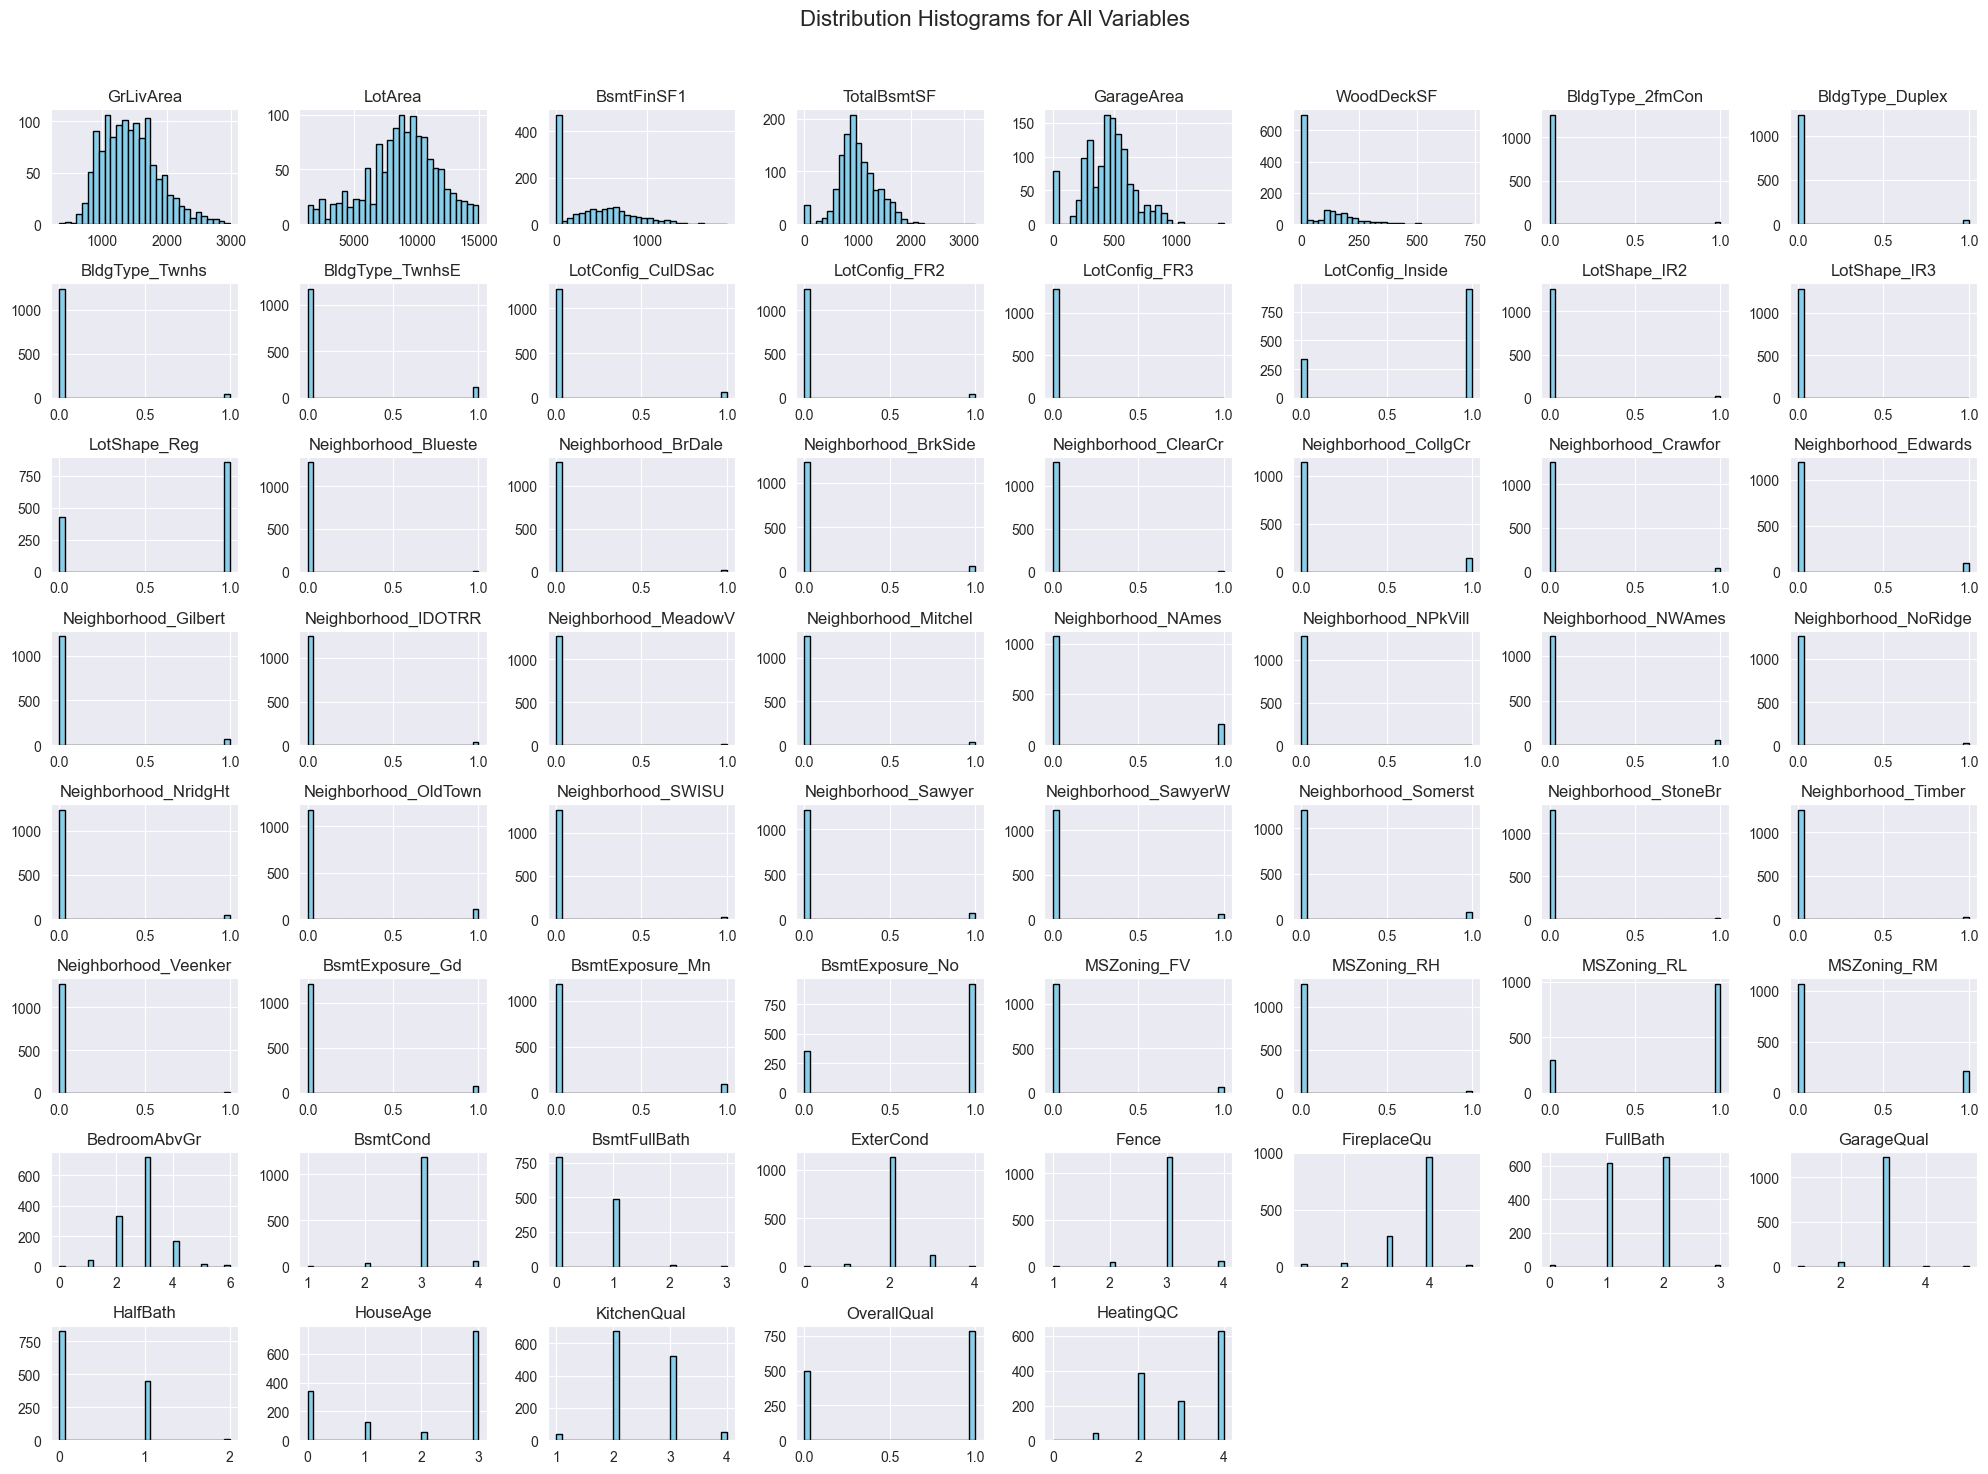

In [193]:
import matplotlib.pyplot as plt

# Plot distribution histograms for all variables
X.hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')
plt.suptitle('Distribution Histograms for All Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

# Ensure X contains only numeric columns
X_numeric = X.select_dtypes(include=['float64', 'int64', 'int32', 'uint8','int8'])

# Standard Scaling
standard_scaler = StandardScaler()
X_standard_scaled = pd.DataFrame(
    standard_scaler.fit_transform(X_numeric), columns=X_numeric.columns
)

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(
    minmax_scaler.fit_transform(X_numeric), columns=X_numeric.columns
)

# Display results for comparison
X_minmax_scaled.head(),X_standard_scaled

(   GrLivArea   LotArea  BsmtFinSF1  TotalBsmtSF  GarageArea  WoodDeckSF  \
 0   0.520424  0.523311    0.375532     0.266999    0.394245    0.000000   
 1   0.350983  0.607480    0.520213     0.393637    0.330935    0.404891   
 2   0.549168  0.728244    0.258511     0.286962    0.437410    0.000000   
 3   0.523071  0.603821    0.114894     0.235808    0.461871    0.000000   
 4   0.704992  0.948547    0.348404     0.357143    0.601439    0.260870   
 
    BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  ...  \
 0              0.0              0.0             0.0              0.0  ...   
 1              0.0              0.0             0.0              0.0  ...   
 2              0.0              0.0             0.0              0.0  ...   
 3              0.0              0.0             0.0              0.0  ...   
 4              0.0              0.0             0.0              0.0  ...   
 
    ExterCond     Fence  FireplaceQu  FullBath  GarageQual  HalfBath  Ho

In [195]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y, test_size=0.2, random_state=42)

# Display processed data information
X_train.head(), y_train.head()

(      GrLivArea   LotArea  BsmtFinSF1  TotalBsmtSF  GarageArea  WoodDeckSF  \
 914    0.111952  0.012955    0.270745     0.196507    0.205755    0.000000   
 707    0.284418  0.885603    0.274468     0.319401    0.348201    0.000000   
 1088   0.336611  0.625192    0.000000     0.000000    0.332374    0.000000   
 344    0.171710  0.449828    0.141489     0.245789    0.000000    0.000000   
 135    0.381997  0.361560    0.000000     0.279476    0.172662    0.271739   
 
       BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  ...  \
 914               0.0              0.0             0.0              1.0  ...   
 707               0.0              0.0             0.0              0.0  ...   
 1088              0.0              1.0             0.0              0.0  ...   
 344               0.0              0.0             0.0              0.0  ...   
 135               0.0              0.0             0.0              0.0  ...   
 
       ExterCond     Fence  Fireplac

In [196]:
### Models 1, 2, 3
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}
    
# Define parameter grids for each model
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
elastic_net_params = {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]}

# Initialize GridSearchCV for each model
ridge_grid = GridSearchCV(Ridge(random_state=42), ridge_params, scoring='r2', cv=5)
lasso_grid = GridSearchCV(Lasso(random_state=42), lasso_params, scoring='r2', cv=5)
elastic_net_grid = GridSearchCV(ElasticNet(random_state=42), elastic_net_params, scoring='r2', cv=5)

# Perform hyperparameter tuning
ridge_grid.fit(X_train, y_train)
lasso_grid.fit(X_train, y_train)
elastic_net_grid.fit(X_train, y_train)

# Best models
best_ridge = ridge_grid.best_estimator_
best_lasso = lasso_grid.best_estimator_
best_elastic_net = elastic_net_grid.best_estimator_

# Retrain on the full training data with the best hyperparameters
best_ridge.fit(X_train, y_train)
best_lasso.fit(X_train, y_train)
best_elastic_net.fit(X_train, y_train)

# Make predictions
ridge_preds = best_ridge.predict(X_test)
lasso_preds = best_lasso.predict(X_test)
elastic_net_preds = best_elastic_net.predict(X_test)

# Evaluate the tuned models
ridge_metrics = calculate_metrics(y_test, ridge_preds)
lasso_metrics = calculate_metrics(y_test, lasso_preds)
elastic_net_metrics = calculate_metrics(y_test, elastic_net_preds)

# Retrieve the best alpha values for each model
best_ridge_alpha = best_ridge.alpha
best_lasso_alpha = best_lasso.alpha
best_elastic_net_alpha = best_elastic_net.alpha
best_elastic_net_l1_ratio = best_elastic_net.l1_ratio

ridge_metrics, lasso_metrics, elastic_net_metrics

({'MSE': 0.012236432102249478,
  'MAE': 0.08534864113704596,
  'RMSE': np.float64(0.11061840761034973),
  'R2': 0.8899122515539585},
 {'MSE': 0.024352351165303023,
  'MAE': 0.12137324087900933,
  'RMSE': np.float64(0.15605239878099605),
  'R2': 0.7809087251288956},
 {'MSE': 0.013959306561723827,
  'MAE': 0.09026299241907093,
  'RMSE': np.float64(0.11814950935879431),
  'R2': 0.8744120331476589})

In [197]:


# Combine results
alpha_results = {
    "Ridge": {"Alpha": best_ridge_alpha},
    "Lasso": {"Alpha": best_lasso_alpha},
    "ElasticNet": {"Alpha": best_elastic_net_alpha, "L1 Ratio": best_elastic_net_l1_ratio}
}

alpha_results

{'Ridge': {'Alpha': 0.1},
 'Lasso': {'Alpha': 0.01},
 'ElasticNet': {'Alpha': 0.01, 'L1 Ratio': 0.2}}

In [198]:
# WIth K-Fold Validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict

# Set up k-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)

# Perform k-fold validation and evaluate metrics for Ridge, Lasso, and ElasticNet
def k_fold_validation(model, X, y, cv):
    mse = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv).mean()
    mae = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv).mean()
    r2 = cross_val_score(model, X, y, scoring='r2', cv=cv).mean()
    rmse = np.sqrt(mse)
    return {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}

# Ridge
ridge_kfold_metrics = k_fold_validation(Ridge(alpha=.1, random_state=42), X_minmax_scaled, y, kf)

# Lasso
lasso_kfold_metrics = k_fold_validation(Lasso(alpha=0.01, random_state=42), X_minmax_scaled, y, kf)

# ElasticNet
elastic_net_kfold_metrics = k_fold_validation(ElasticNet(alpha=0.01, l1_ratio=0.2,max_iter=10000, random_state=42), X_minmax_scaled, y, kf)

ridge_kfold_metrics, lasso_kfold_metrics, elastic_net_kfold_metrics

X_minmax_scaled.to_csv("train_X_minmax.csv", index=False)

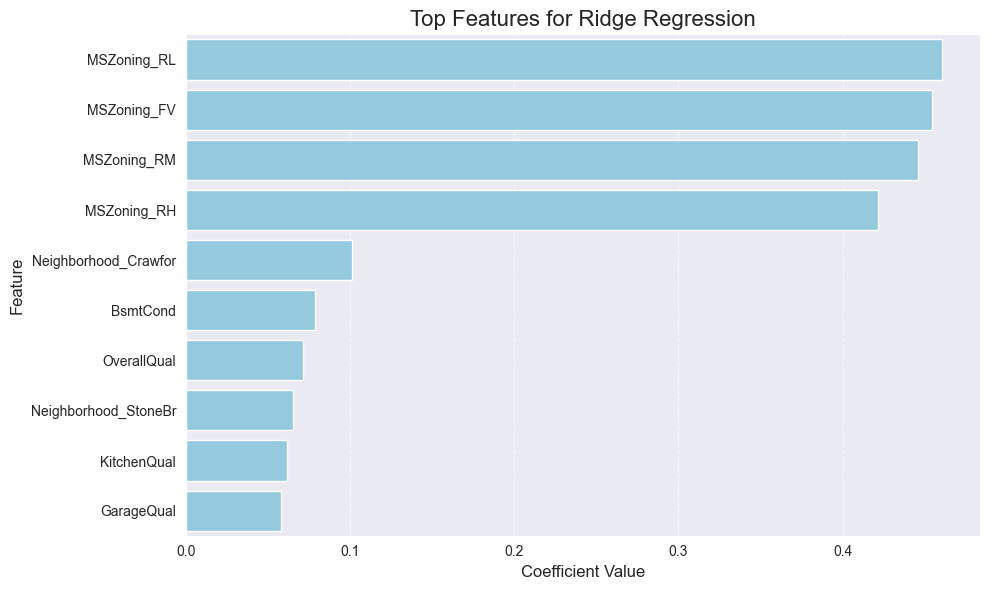

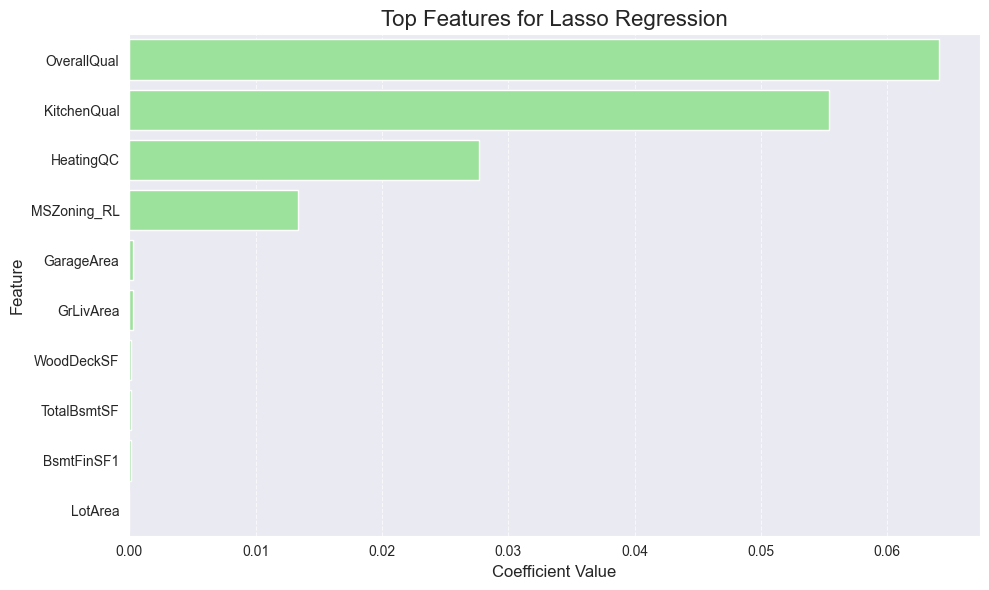

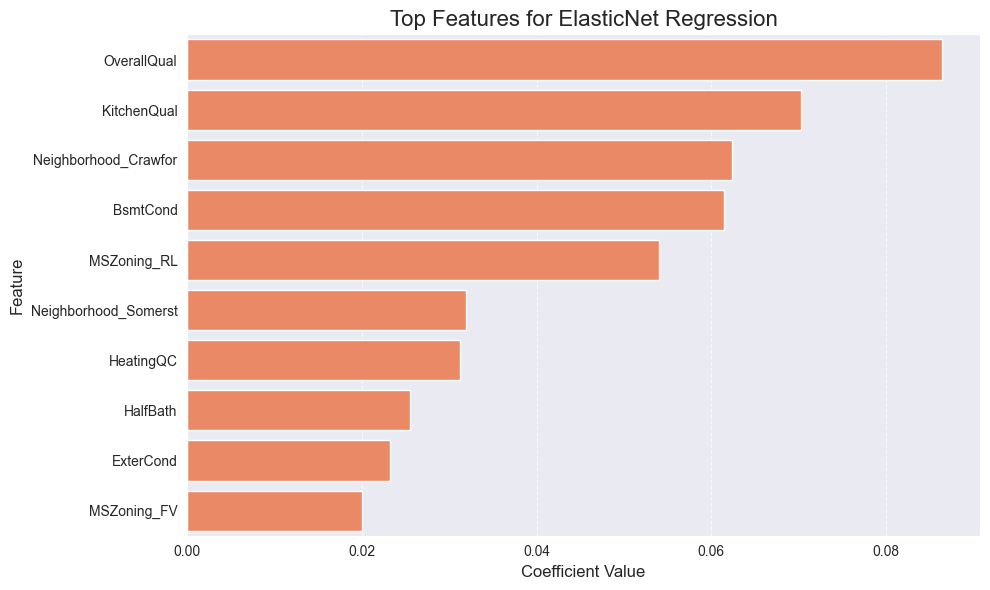

In [199]:
# Define the function to plot top features

def plot_top_features(features_series, title, color):
    """
    Plots the top features from a regression model based on coefficients.
    
    Args:
        features_series (pd.Series): Series containing feature names as index and coefficients as values.
        title (str): Title for the plot.
        color (str): Color for the bars in the plot.
    """
    plt.figure(figsize=(10, 6))
    top_features = features_series[features_series != 0].nlargest(10)
    sns.barplot(x=top_features.values, y=top_features.index, color=color)
    plt.title(f"Top Features for {title}", fontsize=16)
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

X_features = X

# Fit the regression models again to get coefficients
best_ridge.fit(X_features, train_data['logSalePrice'])
best_lasso.fit(X_features, train_data['logSalePrice'])
best_elastic_net.fit(X_features, train_data['logSalePrice'])

# Get coefficients
best_ridge_coefficients = best_ridge.coef_
best_lasso_coefficients = best_lasso.coef_
best_elastic_net_coefficients = best_elastic_net.coef_

# Convert coefficients to pandas Series
best_ridge_features = pd.Series(best_ridge_coefficients, index=X_features.columns).sort_values(ascending=False)
best_lasso_features = pd.Series(best_lasso_coefficients, index=X_features.columns).sort_values(ascending=False)
best_elastic_net_features = pd.Series(best_elastic_net_coefficients, index=X_features.columns).sort_values(ascending=False)

# Plot the top features for each regression model
plot_top_features(best_ridge_features, "Ridge Regression", color="skyblue")
plot_top_features(best_lasso_features, "Lasso Regression", color="lightgreen")
plot_top_features(best_elastic_net_features, "ElasticNet Regression", color="coral")


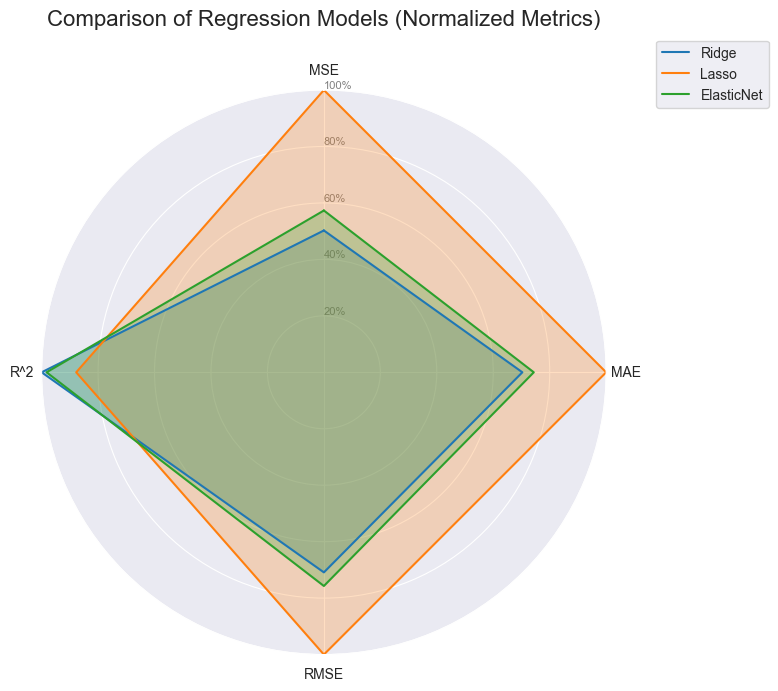

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Example metrics for Ridge, Lasso, and ElasticNet
# Replace these with actual calculated values
metrics = {
    "Ridge": {"MSE": ridge_metrics['MSE'], "MAE": ridge_metrics['MAE'], "RMSE": ridge_metrics['RMSE'], "R^2": ridge_metrics['R2']},
    "Lasso": {"MSE": lasso_metrics['MSE'], "MAE": lasso_metrics['MAE'], "RMSE": lasso_metrics['RMSE'], "R^2": lasso_metrics['R2']},
    "ElasticNet": {"MSE": elastic_net_metrics['MSE'], "MAE": elastic_net_metrics['MAE'], "RMSE": elastic_net_metrics['RMSE'], "R^2": elastic_net_metrics['R2']}
}

# Prepare data for the spider chart
categories = list(metrics["Ridge"].keys())
models = metrics.keys()

# Normalize metrics for better visual comparison
normalized_metrics = {}
for model, values in metrics.items():
    normalized_metrics[model] = [values[metric] / max([metrics[m][metric] for m in models]) for metric in categories]

# Create the spider chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model, values in normalized_metrics.items():
    data = values + values[:1]  # Close the circle
    ax.plot(angles, data, label=model)
    ax.fill(angles, data, alpha=0.25)

# Add category labels to the chart
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
plt.ylim(0, 1)

# Add legend and title
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.title("Comparison of Regression Models (Normalized Metrics)", size=16, y=1.1)
plt.tight_layout()

plt.show()

In [201]:
# Assuming ridge_metrics, lasso_metrics, and elastic_net_metrics are dictionaries with metrics

# Combine the metrics into a single DataFrame
metrics_combined = pd.DataFrame({
    "Ridge": ridge_metrics,
    "Lasso": lasso_metrics,
    "ElasticNet": elastic_net_metrics
}).T  # Transpose to align models as rows

# Rename index and columns for better readability
metrics_combined.index.name = "Model"
metrics_combined.columns = ["MSE", "MAE", "RMSE", "R^2"]

# Display the metrics as a simple table
print(metrics_combined)

                 MSE       MAE      RMSE       R^2
Model                                             
Ridge       0.012236  0.085349  0.110618  0.889912
Lasso       0.024352  0.121373  0.156052  0.780909
ElasticNet  0.013959  0.090263  0.118150  0.874412


In [202]:
# Define the bins and labels for HouseAge
bins = [0, 10, 20, 30, 140]
labels = [1, 2, 3, 4]

# 'HouseAge' derive from 'YearBuilt' and YrSold
test_data['HouseAge'] = test_data['YrSold'] - test_data['YearBuilt']

# Create a new column 'HouseAge' by grouping it into bins
test_data["HouseAge"] = pd.cut(
    test_data["HouseAge"], bins=bins, labels=labels, right=False
)

# Define the bins and labels
bins = [0, 6, float('inf')]  # Define two intervals: [0, 6) and [6, inf)
labels = ['Low', 'High']

# Transform 'OverallQual' from seven categories to two. Purpose is to reduce noise.
test_data["OverallQual"] = pd.cut(
    test_data["OverallQual"], bins=bins, labels=labels, right=False
)

# Ensure the changes are applied correctly by making a copy
test_data = test_data.copy()

data_dummies = pd.get_dummies(test_data, columns=columns_to_dummy, drop_first=True, dtype=int)

test_data = data_dummies

# Display the first few rows of the modified dataset
test_data.head()

test_data = test_data.copy()

numeric_columns = test_data.select_dtypes(include=['float64', 'int64', 'int32', 'uint8','int8']).columns
len(numeric_columns)

78

In [203]:
categorical_columns = test_data.select_dtypes(include=['object', 'category']).columns
len(categorical_columns)

39

In [204]:

# Define ordinal mappings using dictionaries
ordinal_mappings = {
    "BedroomAbvGr": {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8},
    "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtFullBath": {0: 0, 1: 1, 2: 2, 3: 3},
    "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
    "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "FullBath": {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
    "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "HalfBath": {0: 0, 1: 1, 2: 2},
    "HouseAge": {1: 1, 2: 2, 3: 3, 4: 4},
    "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "OverallQual": {"Low": 0, "High": 1},
    "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
}

# Apply ordinal encoding using replace()
for col, mapping in ordinal_mappings.items():
    if col in test_data.columns:
        test_data[col] = test_data[col].replace(mapping)

# Print transformed DataFrame
print(test_data)

X = test_data[X_variables]

# Convert boolean columns to numeric if any exist
bool_columns = test_data.select_dtypes(include=['bool']).columns

# Convert to numeric
test_data[bool_columns] = test_data[bool_columns].astype(int)
X[bool_columns] = X[bool_columns].astype(int)

# Separate numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64', 'int32', 'uint8','int8']).columns
categorical_columns = X.select_dtypes(include=['object','category']).columns

X = X.copy()

# Impute missing values for numerical columns with the mean
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].mean())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    X[col] = X[col].fillna(test_data[col].mode()[0]).astype(int)

# Verify if missing values are handled
missing_values_summary = X.isnull().sum()

pd.set_option('display.max_rows', None)  # Show all rows
print('Missing Value Summary:')
print(missing_values_summary)

# Ensure X contains only numeric columns
X_numeric = X.select_dtypes(include=['float64', 'int64', 'int32', 'uint8'])

print(X_numeric.columns)

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled_test = pd.DataFrame(
    minmax_scaler.fit_transform(X_numeric), columns=X_numeric.columns
)

X_minmax_scaled_test.head()
print(len(X_minmax_scaled_test))


        Id  MSSubClass  LotFrontage  LotArea Street Alley LandContour  \
0     1461          20    80.000000    11622   Pave  Grvl         Lvl   
1     1462          20    81.000000    14267   Pave  Grvl         Lvl   
2     1463          60    74.000000    13830   Pave  Grvl         Lvl   
3     1464          60    78.000000     9978   Pave  Grvl         Lvl   
4     1465         120    43.000000     5005   Pave  Grvl         HLS   
5     1466          60    75.000000    10000   Pave  Grvl         Lvl   
6     1467          20    68.580357     7980   Pave  Grvl         Lvl   
7     1468          60    63.000000     8402   Pave  Grvl         Lvl   
8     1469          20    85.000000    10176   Pave  Grvl         Lvl   
9     1470          20    70.000000     8400   Pave  Grvl         Lvl   
10    1471         120    26.000000     5858   Pave  Grvl         Lvl   
11    1472         160    21.000000     1680   Pave  Grvl         Lvl   
12    1473         160    21.000000     1680   Pave

C:\Users\pgper\AppData\Local\Temp\ipykernel_30432\659211479.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[col] = test_data[col].replace(mapping)
C:\Users\pgper\AppData\Local\Temp\ipykernel_30432\659211479.py:21: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  test_data[col] = test_data[col].replace(mapping)
C:\Users\pgper\AppData\Local\Temp\ipykernel_30432\659211479.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_

In [205]:
# Validate that the columns are identical after cleaning
if set(X_minmax_scaled.columns) == set(X_minmax_scaled_test.columns):
    print("The columns in X_minmax_scaled and X_minmax_scaled_test are identical after cleaning.")
else:
    print("The columns in X_minmax_scaled and X_minmax_scaled_test are NOT identical after cleaning.")

# Optional: Print the columns that are different, if any
columns_in_scaled_not_in_test = set(X_minmax_scaled.columns) - set(X_minmax_scaled_test.columns)
columns_in_test_not_in_scaled = set(X_minmax_scaled_test.columns) - set(X_minmax_scaled.columns)

if columns_in_scaled_not_in_test or columns_in_test_not_in_scaled:
    print("Columns in X_minmax_scaled but not in X_minmax_scaled_test:", columns_in_scaled_not_in_test)
    print("Columns in X_minmax_scaled_test but not in X_minmax_scaled:", columns_in_test_not_in_scaled)


The columns in X_minmax_scaled and X_minmax_scaled_test are identical after cleaning.


In [206]:
# Calculate missing values for each column
missing_data = X_minmax_scaled_test.isnull().sum()
missing_percentage = (missing_data / len(X_minmax_scaled_test)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

Missing Data Summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage (%)]
Index: []


In [207]:
# X_minmax_scaled_test.head()

In [208]:
# Kaggle Submission files

X_test_features = X_minmax_scaled_test

# test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/3_ModelAssign3_Kaggle/test.csv", header=0, sep=",")

# Predict the y responses for the test data
ridge_predictions = best_ridge.predict(X_test_features)
lasso_predictions = best_lasso.predict(X_test_features)
elastic_net_predictions = best_elastic_net.predict(X_test_features)

# Convert predictions back from log scale to the original scale (if 'logSalePrice' was transformed)
ridge_predictions_original = np.exp(ridge_predictions)
lasso_predictions_original = np.exp(lasso_predictions)
elastic_net_predictions_original = np.exp(elastic_net_predictions)

# Store predictions in a DataFrame for comparison
predictions_df = pd.DataFrame({
    "Ridge Predictions": ridge_predictions_original,
    "Lasso Predictions": lasso_predictions_original,
    "ElasticNet Predictions": elastic_net_predictions_original
})

# Create a new table for submission
ridge_submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": ridge_predictions_original
})

# Save to CSV
ridge_submission.to_csv("ridge_submission.csv", index=False)
print("Submission saved to 'ridge_submission.csv'")

# Create a new table for submission
lasso_submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": lasso_predictions_original
})

# Save to CSV
lasso_submission.to_csv("lasso_submission.csv", index=False)
print("Submission saved to 'lasso_submission.csv'")


# Create a new table for submission
elasticnet_submission = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": elastic_net_predictions_original
})

# Save to CSV
elasticnet_submission.to_csv("elasticnet_submission.csv", index=False)
print("Submission saved to 'elasticnet_submission.csv'")


# Display the first few rows of the predictions
print(predictions_df.head())

Submission saved to 'ridge_submission.csv'
Submission saved to 'lasso_submission.csv'
Submission saved to 'elasticnet_submission.csv'
   Ridge Predictions  Lasso Predictions  ElasticNet Predictions
0       39628.552950       55754.442217            45106.660132
1       45964.924372       61369.276318            53984.281961
2       43496.841162       58890.167447            50224.906838
3       47958.471776       64405.733645            56380.455631
4       51388.167204       64402.339638            55685.320036
